# AUTOMATIC EDA

In [2]:
# -------------------------------
# IMPORTS
# -------------------------------

# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression

# Models optimization
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

# Metrics for CLASSIFICATION models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Metrics for REGRESSION models
from sklearn.metrics import mean_squared_error, r2_score

# Selection boxes: ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display


In [3]:
# -------------------------------
# INPUTS
# -------------------------------

# INPUT BOXES
font_size = "12px"   # Global font size
cell_width = "100px" # Width for all cells
cell_height = "30px" # Height for all cells
max_table_width = "90000px"  # Width of visible table area before horizontal scroll

# PATHS
data_separator = ";"
input_path = "/workspaces/logistic-regression-project/data/raw/bank-marketing-campaign-data.csv"
output_path = "../data/processed/"

# AUTOMATIC PROPOSAL OF ATTRIBUTE'S DATA TYPE
var_type_proposal_threshold = 0.01 # [%] Under this percentage of unique values, the attribute would be proposed as CATEGORIC

# PLOTS FOR VARIABLE ANALYSIS
make_plots = True
figHeight_unit = 8 # Unitary figure height
figWidth_unit = 12 # Unitary figure width
num_cols = 2 # Number of columns per plot
my_palette = "pastel"
my_font_size = 15
num_values_to_plot = 40 # Max number of different values to plot (for CATEGORY_var)
num_bins = 100# Num of bins (for NUMERIC_var plots)

# NOISY ATTRIBUTES (HIGHLY CORRELATED)
corr_threshold = 0.9  # Correlation level considered as "too high"

# OUTLIERS
low_outliers_threshold = 1.0   # [%] Max percentage of lower outliers allowed to remove
up_outliers_threshold = 3.0  # [% ]Max percentage of upper outliers allowed to remove
removal_type = "EXTREME OUTLIERS" # Removal logic type (NORMAL or EXTREME outliers)

# MISSING VALUES
th_fill = 5.0   # [%] If missing perc > th_fill → fill by grouped median, otherwise drop rows

# SPLIT
my_test_size = 0.2
random_seed = 42

# FEATURE SELECTION
feature_keeping_threshold = 100 # [%] Percentaje of features to keep (SelectKBest) 

In [4]:
# -------------------------------
# STEP 0) LOAD RAW DATAFRAME
# -------------------------------
print("STEP 0) LOAD RAW DATAFRAME")

# Read DataFrame
df_raw=pd.read_csv(input_path, sep = data_separator)

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# -------------------------------
# STEP 1) EXPLORE DATAFRAME
# -------------------------------
print("STEP 1) EXPLORE DATAFRAME")

# Copy  of previous DataFrame
df_S1 = df_raw.copy()

print(f"- ℹ️ Shape of the original DataFrame: {df_S1.shape}")

print("- ℹ️ Content of the original DataFrame:")
display(df_S1.head(5))

print("- ℹ️ Info of the original DataFrame (dataType and non-nul values):")
display(df_S1.info())

# Count attributes
df_S1_summary = pd.DataFrame({
    "Column": df_S1.columns,
    "Unique_Count": df_S1.nunique().values
})
print(" - ℹ️ Final DataFrame unique attributes:")
display(df_S1_summary)

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# -------------------------------
# STEP 2) REMOVE DUPLICATES
# -------------------------------
print("STEP 2) REMOVE DUPLICATES")

# Copy  of previous DataFrame
df_S2 = df_S1.copy()

num_duplicates=df_S2.duplicated().sum()
if num_duplicates == 0:
    df_S2=df_S2
    print("- ✅ Original DataFrame does not contain duplicates:")
else:
    df_S2_duplicates=df_S2[df_S2.duplicated()] #Works as bool mask
    df_S2=df_S2.drop_duplicates()
    print("- ⚠️ Original DataFrame contained " + str(num_duplicates) + " duplicates that have been dropped\n")
    print("- ℹ️ These are the dropped duplicates:")
    display(df_S2_duplicates)

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# -------------------------------
# STEP 3) SELECT RELEVANT ATTRIBUTES
# -------------------------------
print("STEP 3) SELECT RELEVANT ATTRIBUTES")

# Copy  of previous DataFrame
df_S3 = df_S2.copy()

# List of columns
columns = df_S3.columns.tolist()

# -------------------------------
# HEADER ROW
# -------------------------------
header_cells = [widgets.Label(value="", layout=widgets.Layout(width=cell_width, height=cell_height))]
for i in range(len(columns)):
    header = widgets.Label(
        value=f"col_{i}",
        layout=widgets.Layout(width=cell_width, height=cell_height)
    )
    header.style = {'font_size': font_size}
    header_cells.append(header)
header_row = widgets.HBox(header_cells)

# -------------------------------
# DROP/KEEP ROW
# -------------------------------
keep_col_drop_down_cells = [widgets.Label(value="Keep col.?", layout=widgets.Layout(width=cell_width, height=cell_height))]
keep_col = []
for i in range(len(columns)):
    drop = widgets.Dropdown(
        options=[True, False],
        value=True,
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'}
    )
    keep_col_drop_down_cells.append(drop)
    keep_col.append(drop)
drop_row = widgets.HBox(keep_col_drop_down_cells)

# -------------------------------
# COL NAME ROW
# -------------------------------
col_name_cells = [widgets.Label(value="Col. name", layout=widgets.Layout(width=cell_width, height=cell_height))]
col_name = []
for i in range(len(columns)):
    text = widgets.Text(
        value=columns[i],
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'}
    )
    text.style = {'font_size': font_size}
    col_name.append(text)
    col_name_cells.append(text)
name_row = widgets.HBox(col_name_cells)

# -------------------------------
# TARGET ATTRIBUTE ROW
# -------------------------------
target_var_drop_down_cells = [widgets.Label(value="Is the target var.?", layout=widgets.Layout(width=cell_width, height=cell_height))]
target_var = []
for i in range(len(columns)):
    trget_var_drop = widgets.Dropdown(
        options=[True, False],
        value=False,
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'}
    )
    target_var_drop_down_cells.append(trget_var_drop)
    target_var.append(trget_var_drop)
target_var_row = widgets.HBox(target_var_drop_down_cells)

# -------------------------------
# Combine into horizontal scrollable table
# -------------------------------
# Make the outer box scrollable horizontally
scrollable_box = widgets.VBox([header_row, drop_row, name_row, target_var_row])
scrollable_box.layout = widgets.Layout(
    overflow_x='auto',
    width=max_table_width,
    height='auto'
)

display(scrollable_box)


STEP 0) LOAD RAW DATAFRAME
--------------------------------------------------------------
--------------------------------------------------------------

STEP 1) EXPLORE DATAFRAME
- ℹ️ Shape of the original DataFrame: (41188, 21)
- ℹ️ Content of the original DataFrame:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


- ℹ️ Info of the original DataFrame (dataType and non-nul values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.pric

None

 - ℹ️ Final DataFrame unique attributes:


,Column,Unique_Count
0,age,78
1,job,12
2,marital,4
3,education,8
4,default,3
5,housing,3
6,loan,3
7,contact,2
8,month,10
9,day_of_week,5


--------------------------------------------------------------
--------------------------------------------------------------

STEP 2) REMOVE DUPLICATES
- ⚠️ Original DataFrame contained 12 duplicates that have been dropped

- ℹ️ These are the dropped duplicates:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


--------------------------------------------------------------
--------------------------------------------------------------

STEP 3) SELECT RELEVANT ATTRIBUTES


In [5]:
# Validate box inputs
for i in range(len(keep_col)):
    if  keep_col[i].value not in [True, False]:
        raise ValueError("- ❌ Missing Keep/Drop selection in column " + str(i))

for i in range(len(col_name)):
    if col_name[i].value.strip() == "":
        raise ValueError("- ❌ Empty column name found for column " + str(i))

for i in range(len(target_var)):
    if  target_var[i].value not in [True, False]:
        raise ValueError("- ❌ Missing target attribute selection in column " + str(i))
    
target_var_true_count = 0    
for i in range(len(target_var)):
    if target_var[i].value == True:
        target_var_true_count += 1
        if keep_col[i].value == False:
            raise ValueError("❌ Target attribute cannot be dropped!")
if target_var_true_count == 0:
    raise ValueError("❌ You must select exactly one target attribute (none selected)")
if target_var_true_count > 1:
    raise ValueError("❌ You must select exactly one target attribute (selected " + str(target_var_true_count) + ")")


print("- ✅ All selections, column names and target attribute validated successfully")

# Build KEEP bolean mask and rename dictionary
keep_mask = []
rename_dict = {}
for i in range(len(columns)):
    keep_mask.append(keep_col[i].value)
    rename_dict[columns[i]] = col_name[i].value

# Rename columns
df_S3 = df_S3.rename(columns=rename_dict)

# List of columns
columns = df_S3.columns.tolist()

# Select target attribute
for i in range(len(target_var)):
    if target_var[i].value == True:
        y_var = columns[i]
    
# Drop non-relevant columns
df_S3=df_S3.loc[:, keep_mask]

# Print results
print("- ✅ Non-Relevant attributes have been dropped.")
print(f" - ℹ️ Original df's columns: {len(df_S2.columns)}")
print(f" - ℹ️ Cleaned df's  columns: {len(df_S3.columns)}")
print(f" - ℹ️ Final DataFrame shape: {df_S3.shape}")
display(df_S3.head())

# Count attributes
df_S3_summary = pd.DataFrame({
    "Column": df_S3.columns,
    "Unique_Count": df_S3.nunique().values
})
print(" - ℹ️ Final DataFrame unique attributes:")
display(df_S3_summary)

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# -------------------------------
# STEP 4) CLASSIFY ATTRIBUTES AND TARGET VARIABLE
# -------------------------------
print("STEP 4) CLASSIFY ATTRIBUTES AND TARGET VARIABLE")

# Copy  of previous DataFrame
df_S4= df_S3.copy()

# List of columns
columns = df_S4.columns.tolist()

# Iterate through columns
category_var_auto = []
numeric_var_auto = []
for col in df_S4.columns:
    col_data = df_S4[col].dropna()
    total_rows = len(df_S4)

    # Skip empty columns
    if total_rows == 0:
        continue
    
    # Define local variables for each loop
    unique_count = col_data.nunique()
    unique_ratio = unique_count / total_rows * 100
    col_dtype = str(df_S4[col].dtype)

    # Case 1: text-based columns
    if col_dtype in ["object", "category"]:
        category_var_auto.append(col)
        continue
    # Case 2: integer columns
    if col_dtype.startswith("int"):
        if unique_ratio <= var_type_proposal_threshold:
            category_var_auto.append(col)
        else:
            numeric_var_auto.append(col)
        continue
    # Case 3: float columns
    if col_dtype.startswith("float"):
        if unique_ratio <= var_type_proposal_threshold:
            category_var_auto.append(col)
        else:
            numeric_var_auto.append(col)
        continue

# Print proposed Data Types
print("- ℹ️ Proposed CATEGORY Attributes: " + str(category_var_auto))
print("- ℹ️ Proposed NUMERIC Attributes: " + str(numeric_var_auto))

# -------------------------------
# HEADER ROW
# -------------------------------
header_cells = [widgets.Label(value="", layout=widgets.Layout(width=cell_width, height=cell_height))]
for i in range(len(columns)):
    header = widgets.Label(
        value=columns[i],
        layout=widgets.Layout(width=cell_width, height=cell_height)
    )
    header.style = {'font_size': font_size}
    header_cells.append(header)
header_row = widgets.HBox(header_cells)

# -------------------------------
# DATA TYPE ROW
# -------------------------------
data_type_drop_down_cells = [widgets.Label(value="Data type:", layout=widgets.Layout(width=cell_width, height=cell_height))]
data_type = []
for i in range(len(columns)):
    if columns[i] in category_var_auto:
        data_type_value = "CATEGORY"
    else:
        data_type_value = "NUMERIC"
    data_type_drop = widgets.Dropdown(
        options=["CATEGORY", "NUMERIC"],
        value=data_type_value,
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'}
    )
    data_type_drop_down_cells.append(data_type_drop)
    data_type.append(data_type_drop)
data_type_row = widgets.HBox(data_type_drop_down_cells)

# -------------------------------
# COMBINATION ATTRIBUTE FOR MULTIVARIANT ANALYSIS ROW
# -------------------------------
combi_var_drop_down_cells = [widgets.Label(value="Combination att.", layout=widgets.Layout(width=cell_width, height=cell_height))]
combi_var = []
for i in range(len(columns)):
    combi_var_drop = widgets.Dropdown(
        options=[True, False],
        value=False,
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'}
    )
    combi_var_drop_down_cells.append(combi_var_drop)
    combi_var.append(combi_var_drop)
combi_var_row = widgets.HBox(combi_var_drop_down_cells)

# -------------------------------
# Combine into horizontal scrollable table
# -------------------------------
# Make the outer box scrollable horizontally
scrollable_box = widgets.VBox([header_row, data_type_row,combi_var_row])
scrollable_box.layout = widgets.Layout(
    overflow_x='auto',
    width=max_table_width,
    height='auto'
)

display(scrollable_box)

- ✅ All selections, column names and target attribute validated successfully
- ✅ Non-Relevant attributes have been dropped.
 - ℹ️ Original df's columns: 21
 - ℹ️ Cleaned df's  columns: 18
 - ℹ️ Final DataFrame shape: (41176, 18)


,age,job,marital,education,default,housing,loan,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


 - ℹ️ Final DataFrame unique attributes:


,Column,Unique_Count
0,age,78
1,job,12
2,marital,4
3,education,8
4,default,3
5,housing,3
6,loan,3
7,duration,1544
8,campaign,42
9,pdays,27


--------------------------------------------------------------
--------------------------------------------------------------

STEP 4) CLASSIFY ATTRIBUTES AND TARGET VARIABLE
- ℹ️ Proposed CATEGORY Attributes: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome', 'y']
- ℹ️ Proposed NUMERIC Attributes: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [6]:
# Validate box inputs
for i in range(len(data_type)):
    if  data_type[i].value not in ["CATEGORY", "NUMERIC"]:
        raise ValueError("- ❌ Missing Data Type selection in column " + columns[i])
print("- ✅ All Data Type selections validated successfully")

combi_var_true_count = 0    
for i in range(len(combi_var)):
    if combi_var[i].value == True:
        combi_var_true_count += 1
        if data_type[i].value == "NUMERIC":
            raise ValueError("❌ Combination attribute for multivariant analysis must be a CATEGORY attribute!")
if combi_var_true_count == 0 and make_plots:
    raise ValueError("❌ You must select exactly one CATEGORY attribute as combination attribute for multivariant analysis (none selected)")
if combi_var_true_count > 1 and make_plots:
    raise ValueError("❌ You must select exactly one CATEGORY attribute as combination attribute for multivariant analysis (selected " + str(combi_var_true_count) + ")")
if make_plots:
    print("- ✅ Combination attribute validated successfully")
else:
    print("- ℹ️ Combination not needed because plots are not drawn")

# Store Attributes by Data Type
category_var = []
numeric_var = []
for i in range(len(columns)):
    if data_type[i].value == "CATEGORY":
        category_var.append(columns[i])
    else:
        numeric_var.append(columns[i])
if y_var in category_var:
    y_var_unique_values = df_S4[y_var].unique()
    if len(y_var_unique_values) == 2:
        is_y_var_binary = True
    else:
        is_y_var_binary = False
print("- ℹ️ Confirmed CATEGORY Attributes: " + str(category_var))
print("- ℹ️ Confirmed NUMERIC Attributes: " + str(numeric_var))
print("- ℹ️ Confirmed target Attribute: " + y_var)
if is_y_var_binary:
    print("- ℹ️ Target Attribute - " + y_var + " is BINARY")
else:
    print("- ℹ️ Target Attribute - " + y_var + " is MULTICLASS")

# Store combination attribute
for i in range(len(columns)):
    if combi_var[i].value == True and data_type[i].value == "CATEGORY":
        cat_var_comb = columns[i]
# Print confirmed Data Types
if make_plots:
    print("- ℹ️ Confirmed combination attribute: " + cat_var_comb)

- ✅ All Data Type selections validated successfully
- ✅ Combination attribute validated successfully
- ℹ️ Confirmed CATEGORY Attributes: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome', 'y']
- ℹ️ Confirmed NUMERIC Attributes: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
- ℹ️ Confirmed target Attribute: y
- ℹ️ Target Attribute - y is BINARY
- ℹ️ Confirmed combination attribute: education


STEP 5 - UNIVARIABLE ANALYSIS
 🏷️ CATEGORY VARIABLES


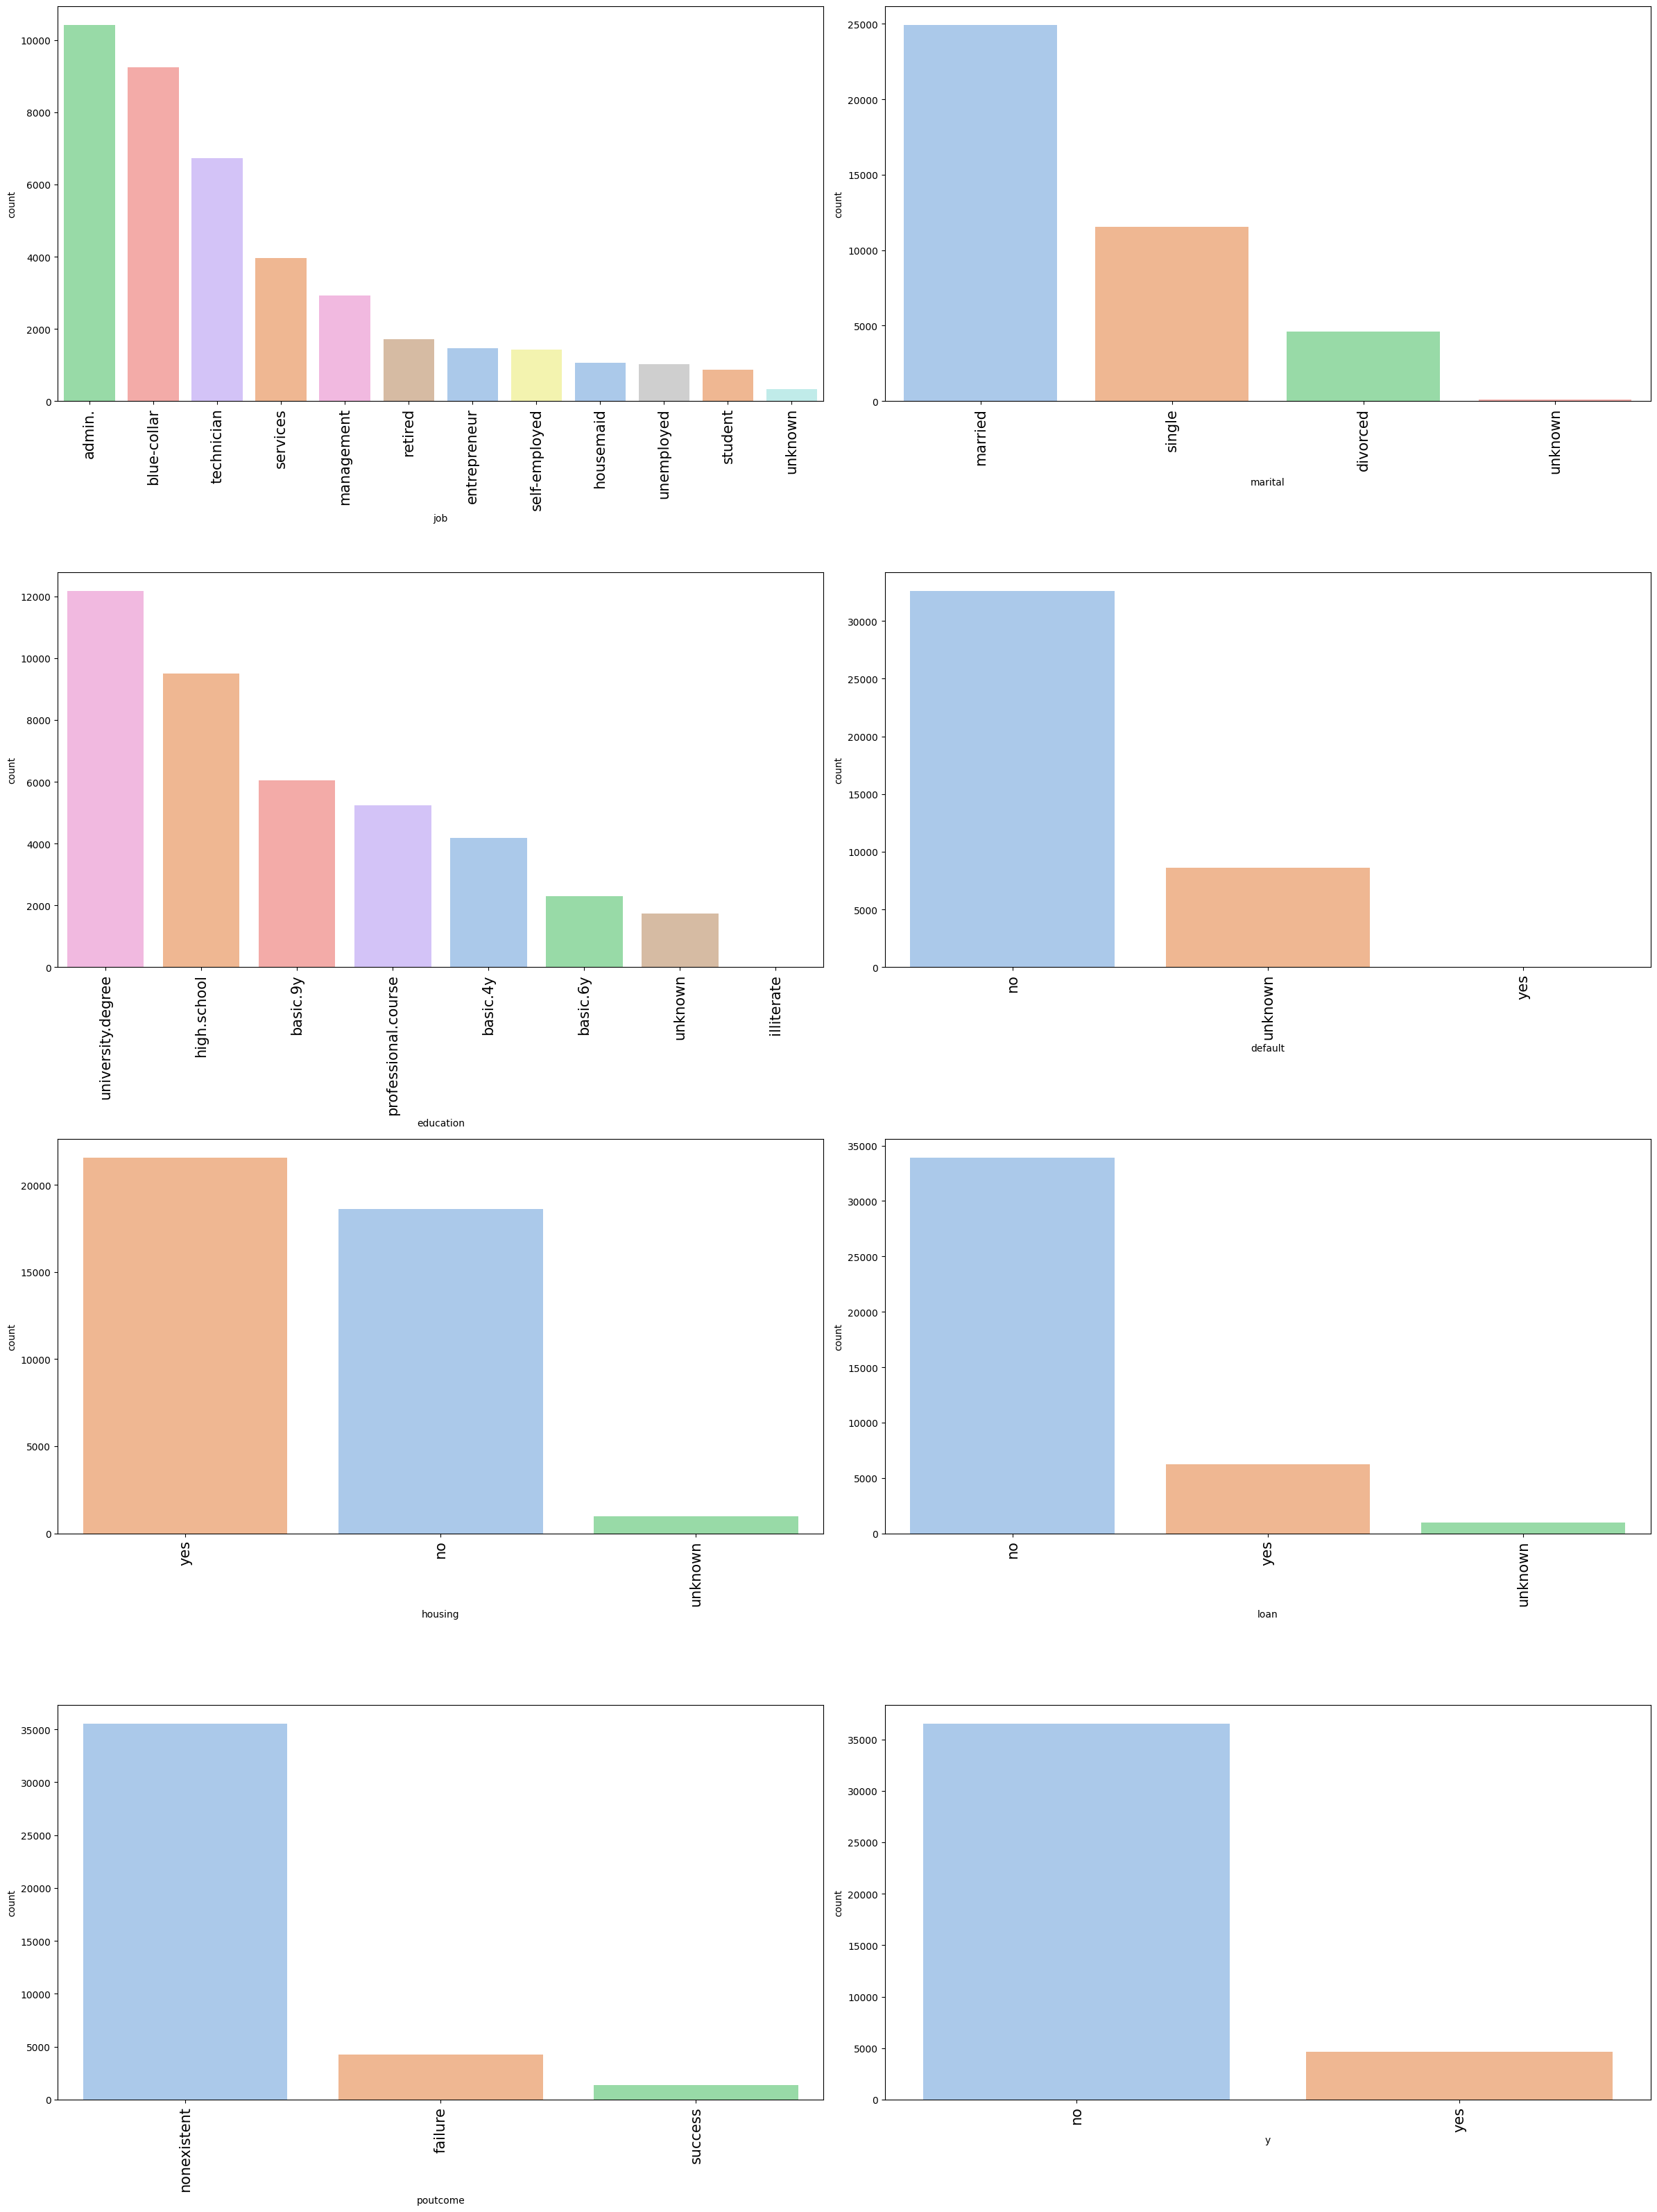

 🔢 NUMERIC VARIABLES


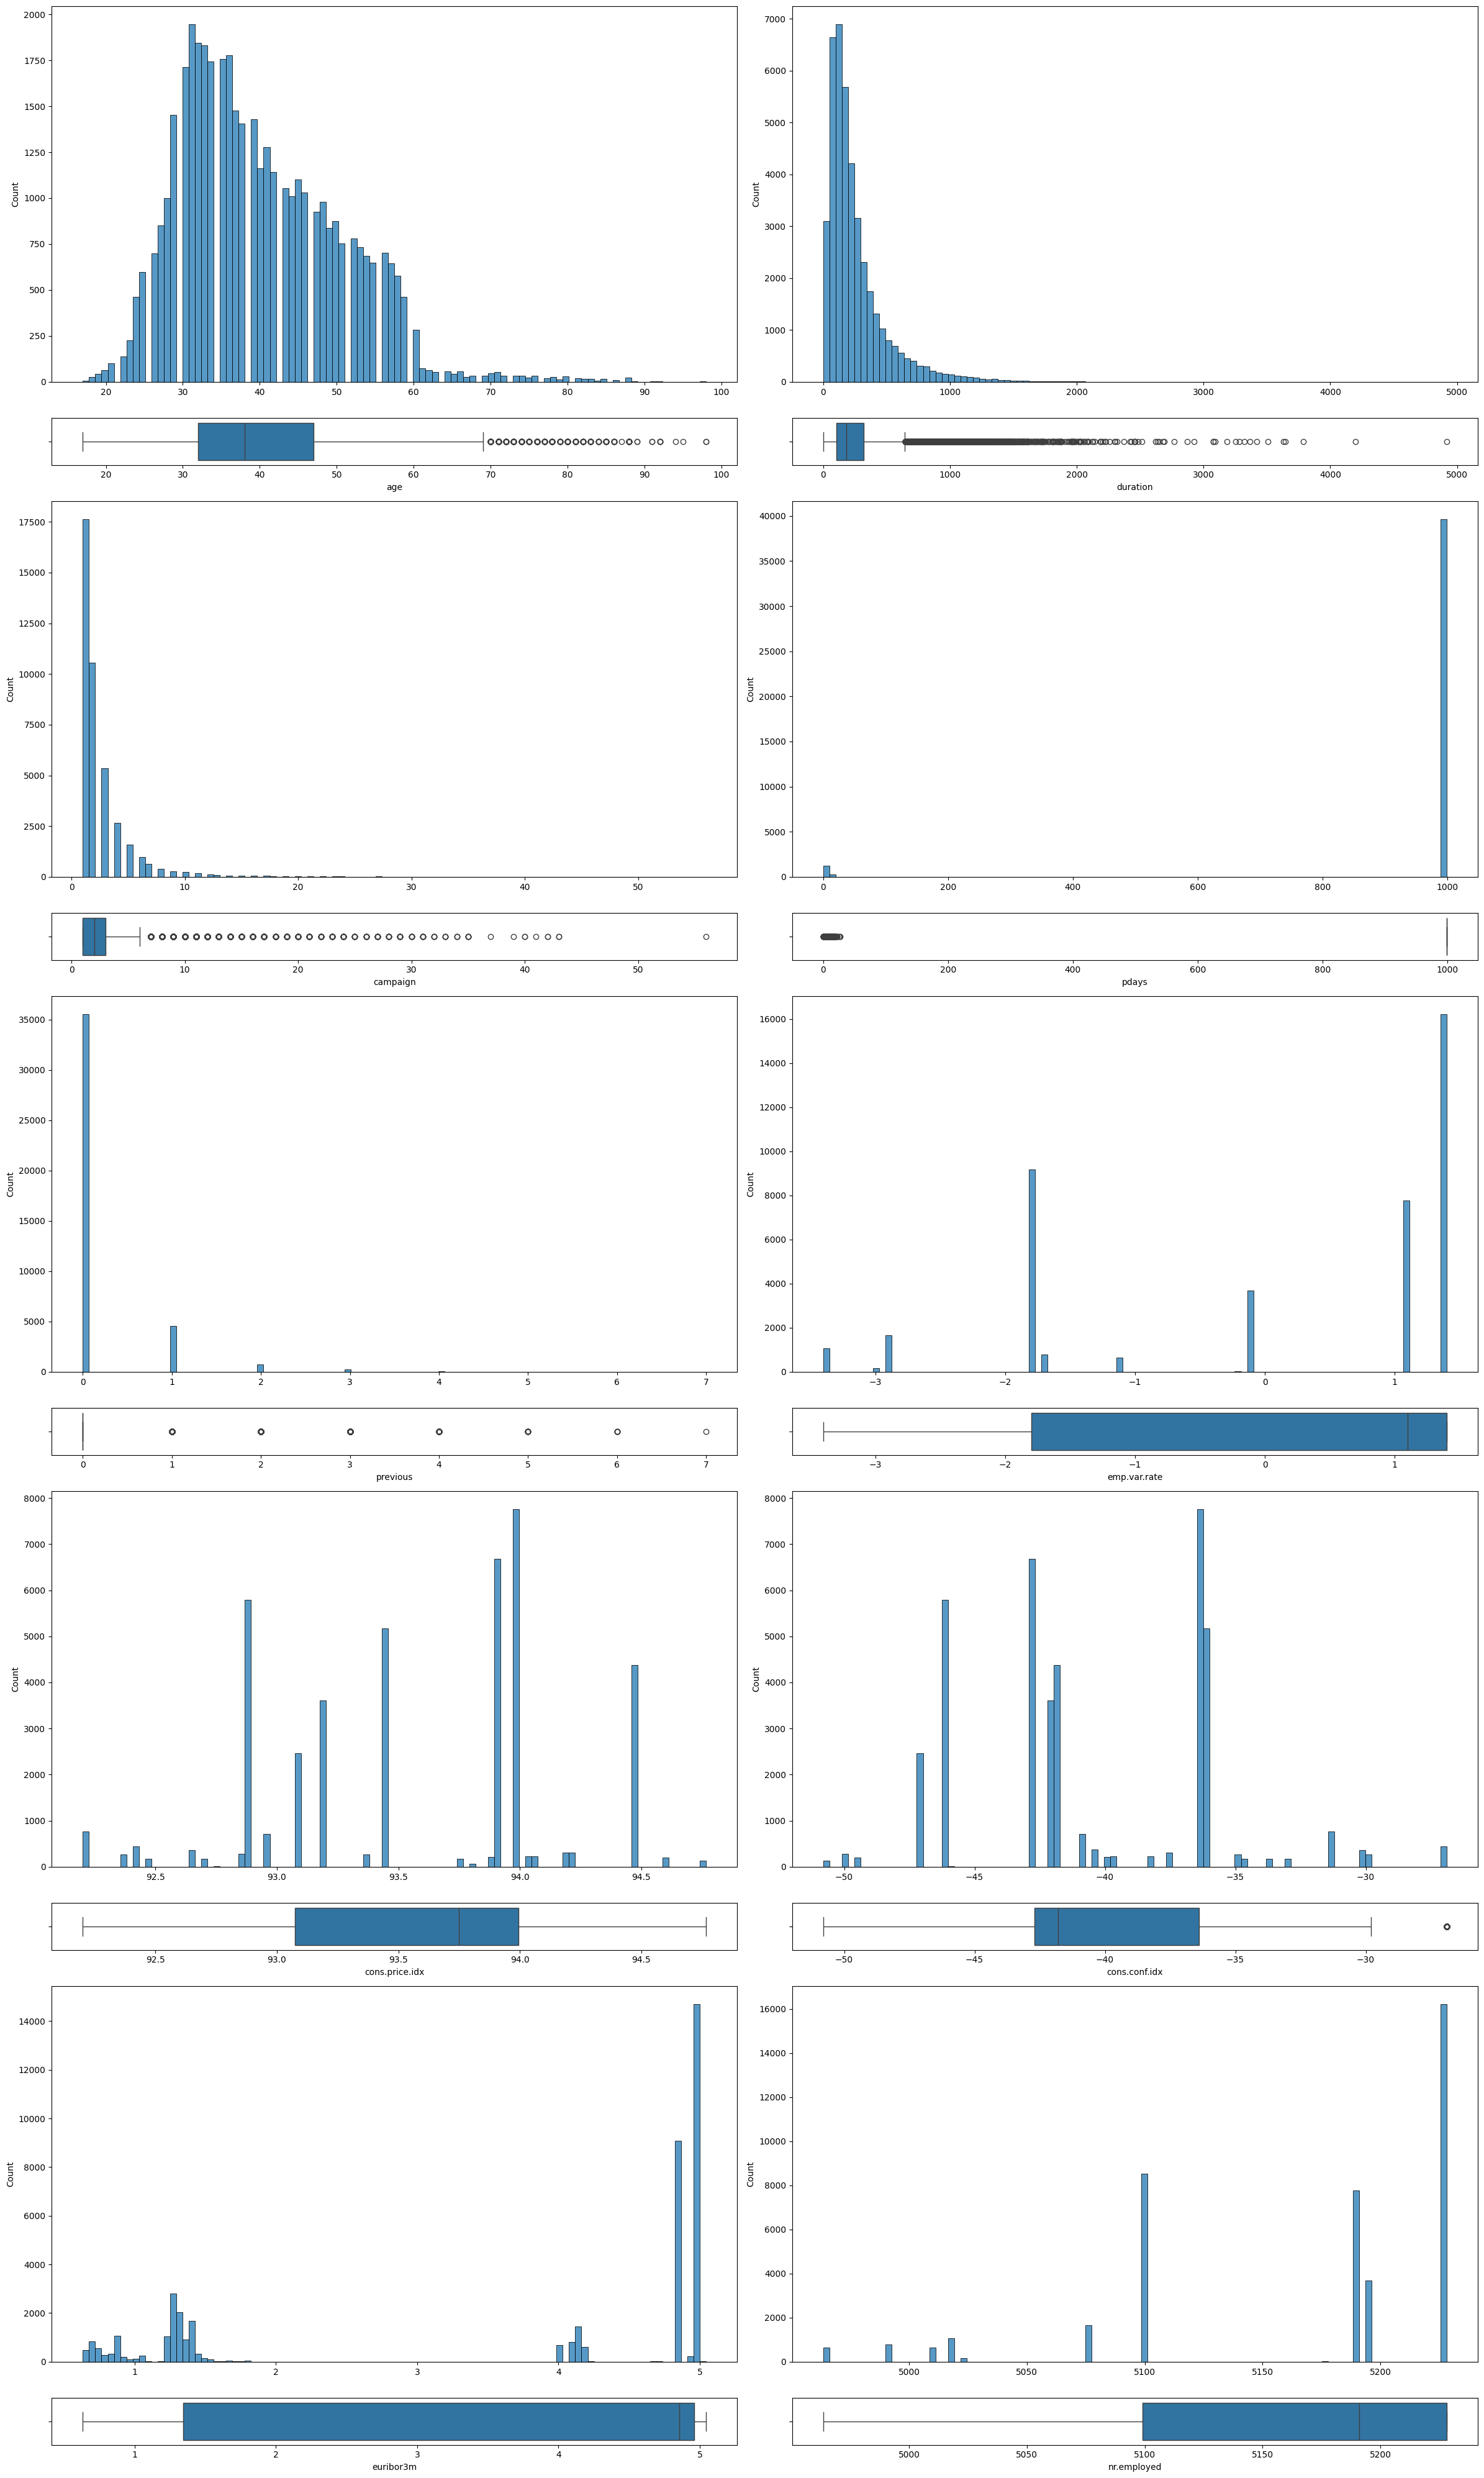

--------------------------------------------------------------
--------------------------------------------------------------

STEP 6 - MULTIVARIANT ANALYSIS - ATTRIBUTES VS TARGET
 🔢 NUMERIC Attributes VS 🔢 NUMERIC Target
This type of plot is non applicable for this case, because the target variable is CATEGORIC
 🏷️ CATEGORY Attributes with 🏷️ Combined CATEGORY Target


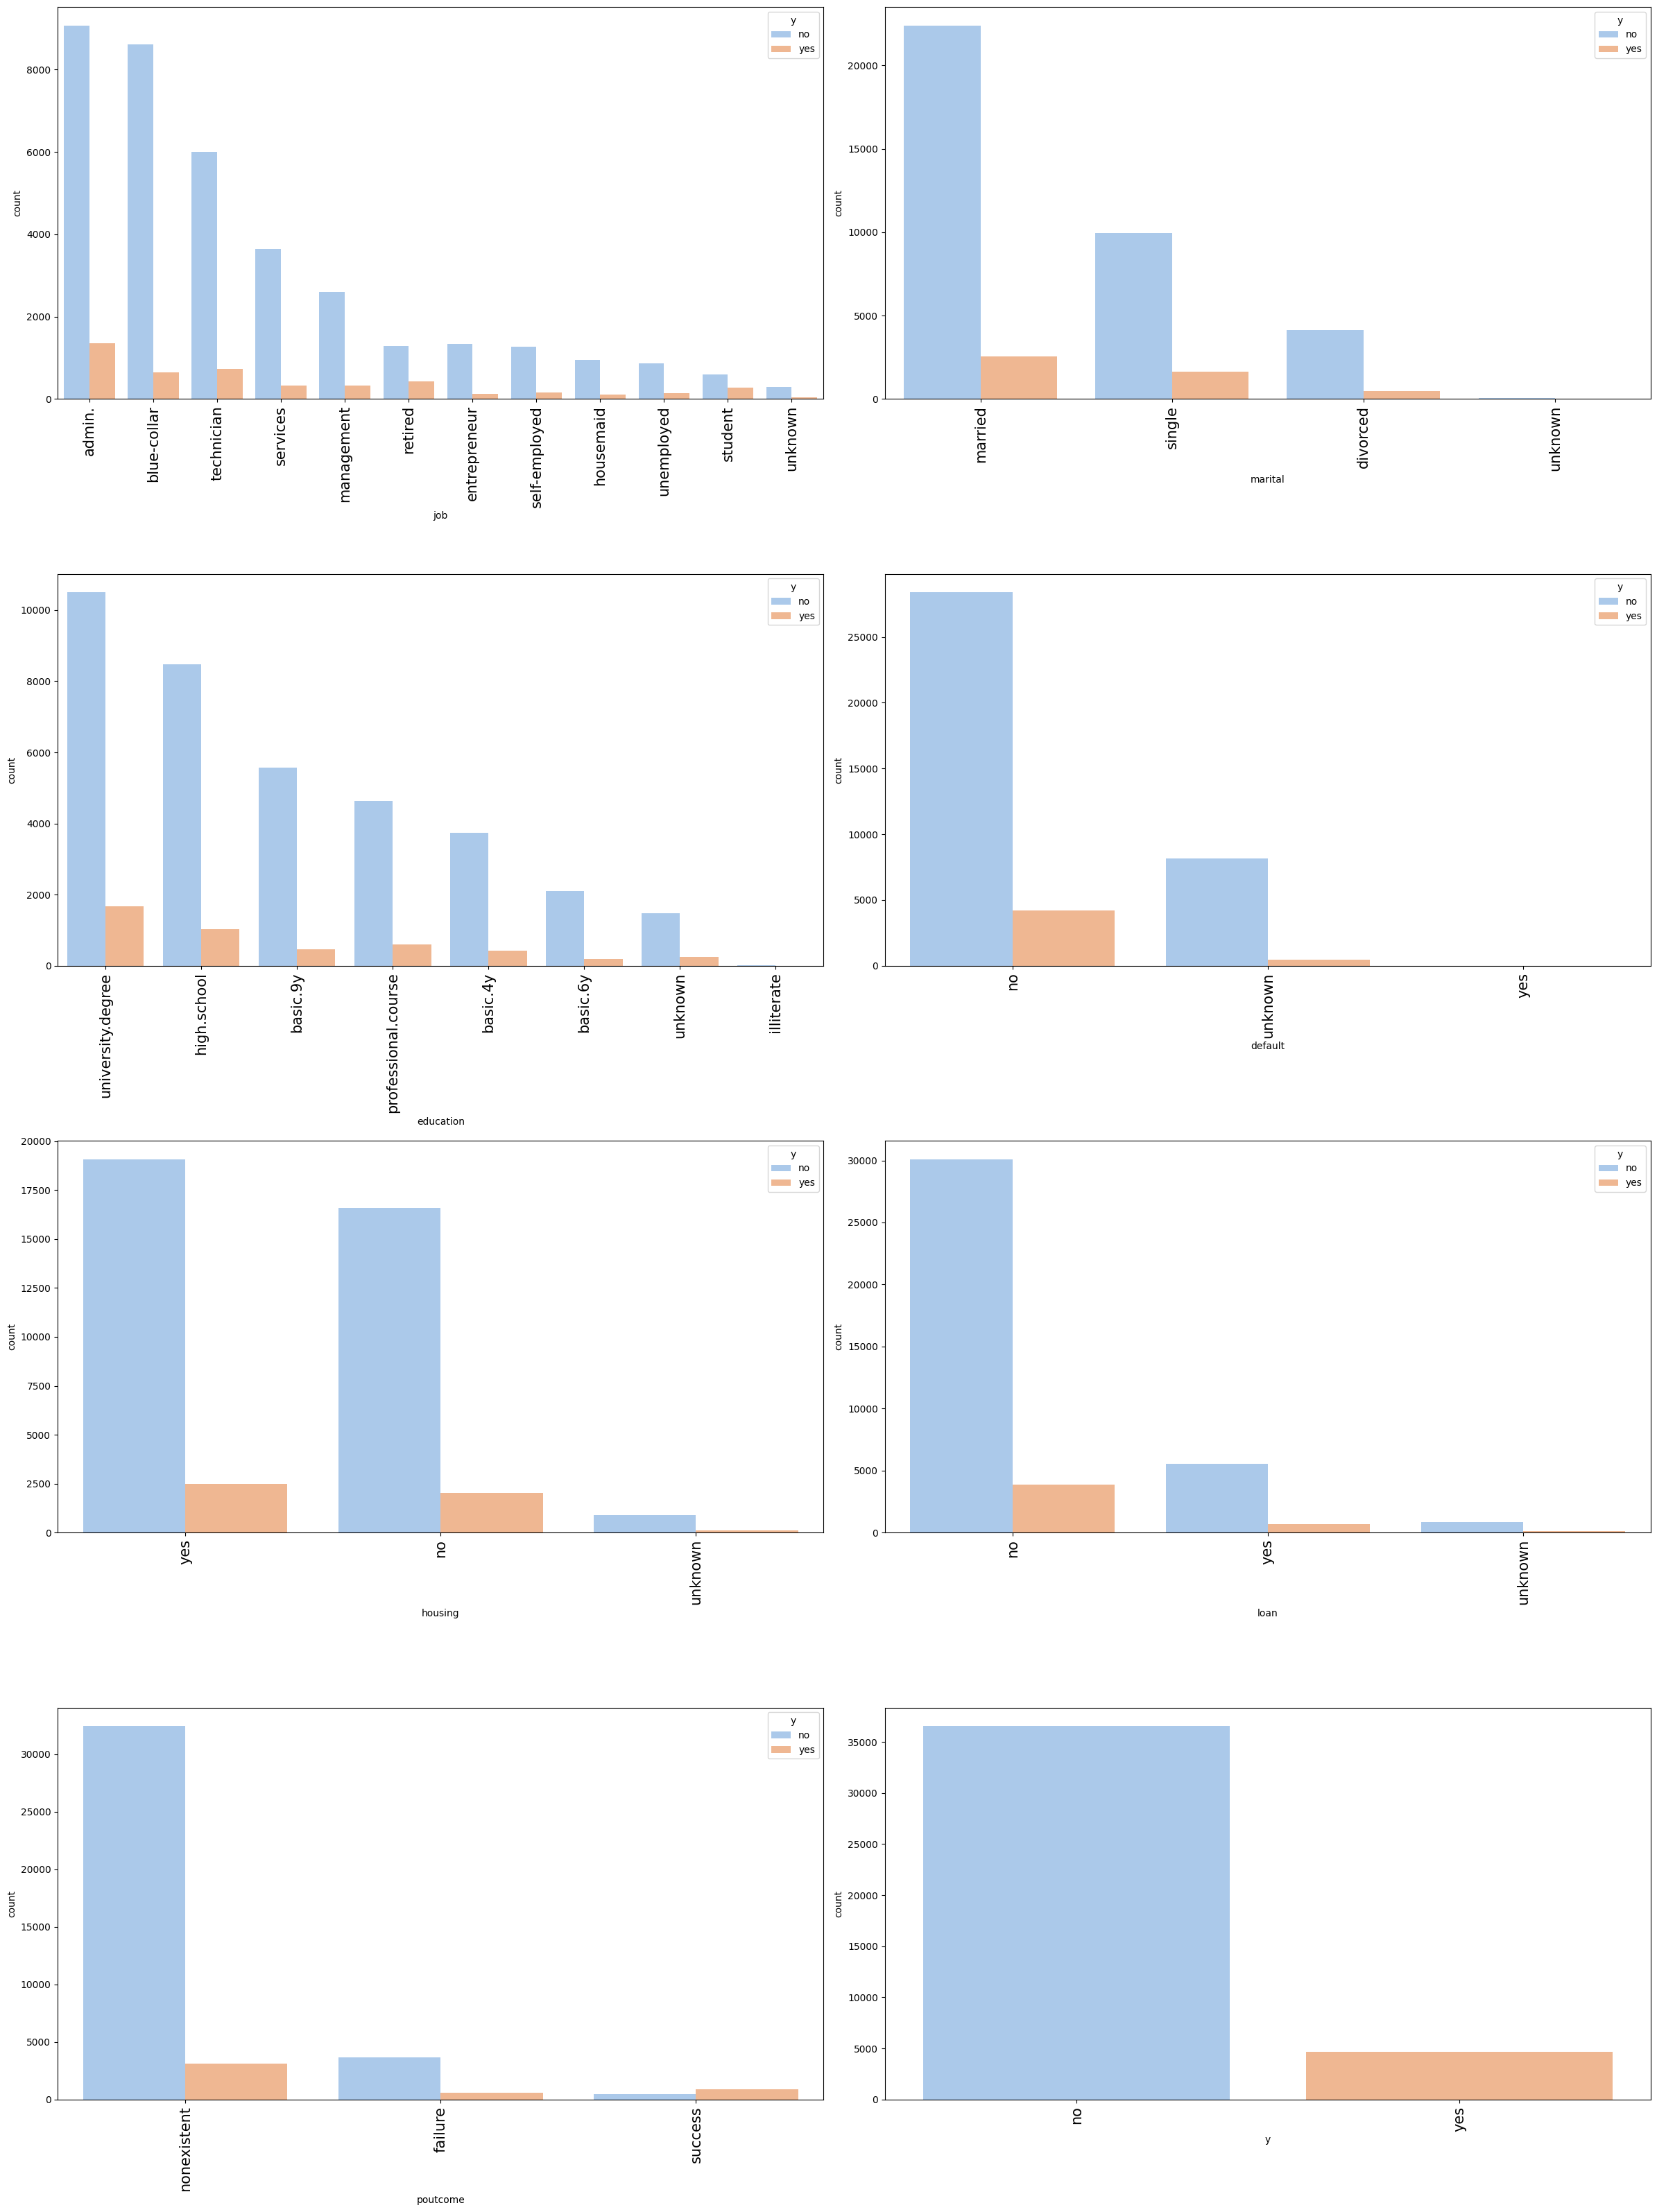

--------------------------------------------------------------
--------------------------------------------------------------

STEP 7 - MULTIVARIANT ANALYSIS - ALL VS ALL
 🔢 NUMERIC VS 🔢 NUMERIC


KeyboardInterrupt: 

In [7]:
# -------------------------------
# STEP 5 - UNIVARIABLE ANALYSIS
# -------------------------------
print("STEP 5 - UNIVARIABLE ANALYSIS")

if not make_plots:
    print("UNIVARIABLE ANALYSIS is not printed, set make_plots = True")
else:
    # Copy  of previous DataFrame
    df_S5 = df_S4.copy()

    
    print("\n 🏷️ CATEGORY VARIABLES")

    # Set plotting variables
    var_to_plot=category_var # Variable type for this plot
    num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure

    # Create subplots
    fig, axes = plt.subplots(
        nrows = num_rows,
        ncols = num_cols,
        figsize=(figWidth_unit * num_cols, figHeight_unit * num_rows))
        
    # Flatten the axes array for easier access
    axes = axes.flatten()  

    # Loop through variables
    idx = 0
    for col in var_to_plot:
        # Count unique values
        unique_count = df_S5[col].nunique()
        
        # Limit the number of plotted categories if there are more than num_values_to_plot
        if unique_count > num_values_to_plot:
            order = df_S5[col].value_counts().head(num_values_to_plot).index
        else:
            order = df_S5[col].value_counts().index
        
        # Create countplot
        sns.countplot(
            ax = axes[idx],
            data = df_S5,
            x = col,
            hue = col,
            palette = my_palette,
            order = order,
            legend = False)
        axes[idx].tick_params(axis='x', rotation=90, labelsize=my_font_size)
        
        # Add text box if truncated
        if unique_count > num_values_to_plot:
            msg = "There are " + str(unique_count) + " different values,\nbut only " + str(num_values_to_plot) + " have been plotted"
            axes[idx].text(
                x = 0.5,
                y = 0.9,
                s = msg,
                transform=axes[idx].transAxes,
                fontsize=my_font_size,
                color='red',
                ha='center',
                va='top',
                bbox=dict(facecolor='grey', alpha=0.25, edgecolor='red'))
        
        idx += 1

    # Turn off unused axes if there are any
    for j in range(idx, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    print("\n 🔢 NUMERIC VARIABLES")

    # Set plotting variables
    var_to_plot=numeric_var # Variable type for this plot
    num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure

    # Create subplots with custom height ratios
    fig, axes = plt.subplots(
        nrows = num_rows * 2,
        ncols =  num_cols,
        figsize=(figWidth_unit * num_cols, figHeight_unit * num_rows),
        gridspec_kw={'height_ratios': [4, 0.5] * num_rows})

    # Loop through variables
    var_idx = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if var_idx >= len(var_to_plot):
                # Hide unused subplots
                axes[row * 2, col].set_visible(False)
                axes[row * 2 + 1, col].set_visible(False)
                continue

            # Histogram (top)
            sns.histplot(
                ax = axes[row * 2, col],
                data = df_S5,
                x = var_to_plot[var_idx],
                bins = num_bins)
            axes[row * 2, col].set_xlabel("")

            # Boxplot (bottom)
            sns.boxplot(
                ax=axes[row * 2 + 1, col],
                data=df_S5,
                x = var_to_plot[var_idx])
            
            var_idx += 1

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# -------------------------------
# STEP 6 - MULTIVARIANT ANALYSIS - ATTRIBUTES VS TARGET
# -------------------------------
print("STEP 6 - MULTIVARIANT ANALYSIS - ATTRIBUTES VS TARGET")

if not make_plots:
    print("MULTIVARIANT ANALYSIS - ATTRIBUTES VS TARGET is not printed, set make_plots = True")
else:
    # Copy  of previous DataFrame
    df_S6 = df_S4.copy()

    print("\n 🔢 NUMERIC Attributes VS 🔢 NUMERIC Target")

    if y_var not in numeric_var:
        print("   This type of plot is non applicable for this case, because the target variable is CATEGORIC")
    else:
        # Set plotting variables
        var_to_plot=numeric_var # Variable type for this plot
        num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure

        # Create subplots with custom height ratios
        fig, axes = plt.subplots(
            nrows = num_rows * 2,
            ncols = num_cols,
            figsize=(figWidth_unit * num_cols, figHeight_unit * num_rows),
            gridspec_kw={'height_ratios': [4, 1] * num_rows})

        # Loop through variables
        var_idx = 0
        for row in range(num_rows):
            for col in range(num_cols):
                if var_idx >= len(var_to_plot):
                    # Hide unused subplots
                    axes[row * 2, col].set_visible(False)
                    axes[row * 2 + 1, col].set_visible(False)
                    continue

                # Regplot (top)
                sns.regplot(
                    ax = axes[row * 2, col],
                    data = df_S6,
                    x = var_to_plot[var_idx],
                    y = y_var,
                    scatter_kws = {'s': my_font_size, 'alpha': 0.6},
                    line_kws = {'color': 'red'})

                # Boxplot (bottom)
                sns.heatmap(
                    ax = axes[row * 2 + 1, col],
                    data = df_S6[[var_to_plot[var_idx], y_var]].corr(),
                    annot = True,
                    fmt = ".2f",
                    cbar = False)

                var_idx += 1

        # Adjust layout
        plt.tight_layout()
        plt.show()
    
    print("\n 🏷️ CATEGORY Attributes with 🏷️ Combined CATEGORY Target")

    if y_var not in category_var:
        print("   This type of plot is non applicable for this case, because the target variable is NUMERIC")
    else:
        # Set plotting variables
        hue_order = sorted(df_S6[y_var].dropna().unique().tolist()) # Determine hue order dynamically
        var_to_plot=category_var # Variable type for this plot
        num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure

        # Create subplots
        fig, axes = plt.subplots(
            nrows = num_rows,
            ncols = num_cols,
            figsize=(figWidth_unit * num_cols, figHeight_unit * num_rows))
            
        # Flatten the axes array for easier access
        axes = axes.flatten()  

        # Loop through variables
        idx = 0
        for col in var_to_plot:
            # Count unique values
            unique_count = df_S6[col].nunique()
            
            # Limit the number of plotted categories if there are more than num_values_to_plot
            if unique_count > num_values_to_plot:
                order = df_S6[col].value_counts().head(num_values_to_plot).index
            else:
                order = df_S6[col].value_counts().index
            
            # Create countplot
            sns.countplot(
                ax = axes[idx],
                data = df_S6,
                x = col,
                hue = y_var,
                hue_order = hue_order,
                palette = my_palette,
                order = order)
            axes[idx].tick_params(axis='x', rotation=90, labelsize=my_font_size)
            
            # Add text box if truncated
            if unique_count > num_values_to_plot:
                msg = "There are " + str(unique_count) + " different values,\nbut only " + str(num_values_to_plot) + " have been plotted"
                axes[idx].text(
                    x = 0.5,
                    y = 0.9,
                    s = msg,
                    transform=axes[idx].transAxes,
                    fontsize=my_font_size,
                    color='red',
                    ha='center',
                    va='top',
                    bbox=dict(facecolor='grey', alpha=0.25, edgecolor='red'))
            
            idx += 1

        # Turn off unused axes if there are any
        for j in range(idx, len(axes)):
            axes[j].set_visible(False)

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# -------------------------------
# STEP 7 - MULTIVARIANT ANALYSIS - ALL VS ALL
# -------------------------------
print("STEP 7 - MULTIVARIANT ANALYSIS - ALL VS ALL")

if not make_plots:
    print("MULTIVARIANT ANALYSIS - ALL VS ALL is not printed, set make_plots = True")
else:
    # Copy  of previous DataFrame
    df_S7 = df_S4.copy()

    print("\n 🔢 NUMERIC VS 🔢 NUMERIC")

    var_to_plot=numeric_var # Variable type for this plot
    num_rows = len(var_to_plot) - 1 # Number of rows (one less than number of variables)

    # Create subplots with two stacked plots (regplot + heatmap) per variable pair
    fig, axes = plt.subplots(
        nrows = num_rows * 2,
        ncols = len(var_to_plot) - 1,
        figsize=(figWidth_unit * (len(var_to_plot) - 1), figHeight_unit * num_rows),
        gridspec_kw={'height_ratios': [4, 1] * num_rows})

    # Flatten axes for easy handling
    axes = np.array(axes)

    # Track subplot usage
    for row in range(num_rows):
        n_cols = len(var_to_plot) - row - 1 # Decreasing number of columns each row
        for col in range(n_cols):

            # Top: regplot
            sns.regplot(
                ax = axes[row * 2, col],
                data = df_S7,
                x = var_to_plot[row + col + 1],
                y = var_to_plot[row],
                scatter_kws = {'s': my_font_size, 'alpha': 0.6},
                line_kws = {'color': 'red'})
            axes[row * 2, col].set_xlabel(var_to_plot[row + col + 1],fontsize=20)

            # Show Y label only for first plot in row
            if col == 0:
                axes[row * 2, col].set_ylabel(var_to_plot[row],fontsize=my_font_size)
            else:
                axes[row * 2, col].set_ylabel("")

            # Bottom: heatmap (correlation)
            sns.heatmap(
                ax = axes[row * 2 + 1, col],
                data = df_S7[[var_to_plot[row + col + 1], var_to_plot[row]]].corr(),
                annot = True,
                fmt = ".2f",
                cbar = False,
                annot_kws = {"size": 20})

        # Hide unused subplots on the right for this row
        for col in range(n_cols, len(var_to_plot) - 1):
            axes[row * 2, col].set_visible(False)
            axes[row * 2 + 1, col].set_visible(False)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    print("\n 🏷️🔢 ALL Attributes VS 🏷️🔢 ALL Attributes")

    # Encode categorical variables using the Series.factorize() method
    for col in category_var:
        codes, uniques = df_S7[col].factorize()
        df_S7[col] = codes  # replace column with integer codes

    # CATEGORY VARIABLES HEATMAP
    if len(category_var) > 1:
        corr_cat = df_S7[category_var].corr()
        fig = plt.figure(figsize=(figWidth_unit, figHeight_unit))
        plt.title("ONLY CATEGORY VARIABLES", fontsize=my_font_size + 2, fontweight="bold")
        sns.heatmap(
            data=corr_cat,
            annot=True,
            vmin=-1,
            vmax=1,
            fmt=".2f",
            annot_kws={"size": my_font_size}
        )
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough categorical variables for a correlation matrix.")

    # NUMERIC VARIABLES HEATMAP
    if len(numeric_var) > 1:
        corr_num = df_S7[numeric_var].corr()
        fig = plt.figure(figsize=(figWidth_unit, figHeight_unit))
        plt.title("ONLY NUMERIC VARIABLES", fontsize=my_font_size + 2, fontweight="bold")
        sns.heatmap(
            data=corr_num,
            annot=True,
            vmin=-1,
            vmax=1,
            fmt=".2f",
            annot_kws={"size": my_font_size}
        )
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough numeric variables for a correlation matrix.")

    # ALL VARIABLES HEATMAP
    corr_matrix = df_S7.corr()
    corr_order = corr_matrix.mean().sort_values(ascending=False).index
    corr_matrix = corr_matrix.loc[corr_order, corr_order]

    fig = plt.figure(figsize=(2 * figWidth_unit, 2 * figHeight_unit))
    plt.title("ALL VARIABLES", fontsize=my_font_size + 2, fontweight="bold")
    sns.heatmap(
        data=corr_matrix,
        annot=True,
        vmin=-1,
        vmax=1,
        fmt=".2f",
        annot_kws={"size": my_font_size}
    )
    plt.tight_layout()
    plt.show()

    # PAIRPLOT (sorted by correlation order)
    fig = plt.figure(figsize=(figWidth_unit, figHeight_unit))
    sns.pairplot(data=df_S7[corr_order])
    plt.show()

In [7]:
# STEP 7.5) REMOVE ATTRIBUTES TO AVOID NOISE
print("STEP 7.5) REMOVE ATTRIBUTES TO AVOID NOISE")

# Copy of previous DataFrame
df_S7_5 = df_S5_2.copy()

# Detect highly correlated numeric features
corr_matrix = df_S7_5[numeric_var].corr().abs()  # Absolute values for correlation strength

# Create an empty set to store columns to drop
to_drop = set()

# Iterate through correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > corr_threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            # Drop one of the two correlated columns (keep the first, drop the second)
            if col_i not in to_drop:
                to_drop.add(col_i)

# Drop the detected "noisy" attributes
if to_drop:
    df_S7_5 = df_S7_5.drop(columns=list(to_drop), axis=1)
    print(f"- ⚠️ High correlation detected (> {corr_threshold}). The following attributes were dropped:")
    for col in to_drop:
        print(f"   • {col}")
else:
    print(f"- ✅ No attributes exceeded the correlation threshold of {corr_threshold}. Nothing was dropped.")

# Display summary information
print(f"- ℹ️ Previous df's columns: {len(df_S5_2.columns)}")
print(f"- ℹ️ Cleaned df's  columns: {len(df_S7_5.columns)}")
print(f"- ℹ️ Final DataFrame shape: {df_S7_5.shape}")

display(df_S7_5.head())


STEP 7.5) REMOVE ATTRIBUTES TO AVOID NOISE
- ⚠️ High correlation detected (> 0.9). The following attributes were dropped:
   • euribor3m
   • nr.employed
- ℹ️ Previous df's columns: 17
- ℹ️ Cleaned df's  columns: 15
- ℹ️ Final DataFrame shape: (41176, 15)


,age,job,marital,education,default,housing,loan,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,y
0,56,housemaid,married,basic.4y,no,no,no,261,1,0,nonexistent,1.1,93.994,-36.4,no
1,57,services,married,high.school,unknown,no,no,149,1,0,nonexistent,1.1,93.994,-36.4,no
2,37,services,married,high.school,no,yes,no,226,1,0,nonexistent,1.1,93.994,-36.4,no
3,40,admin.,married,basic.6y,no,no,no,151,1,0,nonexistent,1.1,93.994,-36.4,no
4,56,services,married,high.school,no,no,yes,307,1,0,nonexistent,1.1,93.994,-36.4,no


In [8]:
# STEP 8.1) DEFINE OUTLIERS
print("STEP 8.1) DEFINE OUTLIERS")

# Copy  of previous DataFrame
df_S8_1=df_S7_5.copy()

# Print info
display(df_S8_1.describe())

# Outliers detection is applied over numeric attributes
cols = []
for col in numeric_var:
    if col in df_S8_1.columns.to_list():
        cols.append(col)

# Initialize containers
lower_limits = []
upper_limits = []
n_outliers_lower = []
n_outliers_upper = []
pct_outliers_lower = []
pct_outliers_upper = []
extreme_lower_limits = []
extreme_upper_limits = []
n_extreme_outliers_lower = []
n_extreme_outliers_upper = []
pct_extreme_outliers_lower = []
pct_extreme_outliers_upper = []

len(df_S8_1.index)

for col in cols:
    Q1 = df_S8_1[col].quantile(0.25)
    Q3 = df_S8_1[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calulate limits
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    extreme_lower = Q1 - 3 * IQR
    extreme_upper = Q3 + 3 * IQR

    # Count num of outliers
    n_low = (df_S8_1[col] < lower).sum()
    n_high = (df_S8_1[col] > upper).sum()
    n_extreme_low = (df_S8_1[col] < extreme_lower).sum()
    n_extreme_high = (df_S8_1[col] > extreme_upper).sum()

    # Percentages of outliers
    pct_low = (n_low / len(df_S8_1.index)) * 100
    pct_high = (n_high / len(df_S8_1.index)) * 100
    pct_extreme_low = (n_extreme_low / len(df_S8_1.index)) * 100
    pct_extreme_high = (n_extreme_high / len(df_S8_1.index)) * 100

    # Save limits
    lower_limits.append(lower)
    upper_limits.append(upper)
    extreme_lower_limits.append(extreme_lower)
    extreme_upper_limits.append(extreme_upper)

    # Save num of outliers
    n_outliers_lower.append(n_low)
    n_outliers_upper.append(n_high)
    n_extreme_outliers_lower.append(n_extreme_low)
    n_extreme_outliers_upper.append(n_extreme_high)

    # Save percentages of outliers
    pct_outliers_lower.append(pct_low)
    pct_outliers_upper.append(pct_high)
    pct_extreme_outliers_lower.append(pct_extreme_low)
    pct_extreme_outliers_upper.append(pct_extreme_high)


# Build DataFrame with all results
df_limits = pd.DataFrame(
    [
        lower_limits,
        upper_limits,
        n_outliers_lower,
        n_outliers_upper,
        pct_outliers_lower,
        pct_outliers_upper
    ],
    columns=cols,
    index=[
        "lower_limit",
        "upper_limit",
        "n_outliers_lower",
        "n_outliers_upper",
        "pct_outliers_lower",
        "pct_outliers_upper"
    ]
)
df_extreme_limits = pd.DataFrame(
    [
        extreme_lower_limits,
        extreme_upper_limits,
        n_extreme_outliers_lower,
        n_extreme_outliers_upper,
        pct_extreme_outliers_lower,
        pct_extreme_outliers_upper
    ],
    columns=cols,
    index=[
        "extreme_lower_limit",
        "extreme_upper_limit",
        "n_extreme_outliers_lower",
        "n_extreme_outliers_upper",
        "pct_extreme_outliers_lower",
        "pct_extreme_outliers_upper"
    ]
)
# Display results
display(df_limits)
display(df_extreme_limits)

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# STEP 8.2) CLEAN OUTLIERS
print("STEP 8.2) CLEAN OUTLIERS")

# Copy  of previous DataFrame
df_S8_2=df_S8_1.copy()

# Outliers detection is applied over numeric attributes
cols = []
for col in numeric_var:
    if col in df_S8_2.columns.to_list():
        cols.append(col)

if removal_type == "NORMAL OUTLIERS":
    # Loop through each column and apply filtering rules
    for col in cols:
        low_limit = df_limits.loc["lower_limit", col]
        high_limit = df_limits.loc["upper_limit", col]
        pct_low = df_limits.loc["pct_outliers_lower", col]
        pct_high = df_limits.loc["pct_outliers_upper", col]
        
        # Remove low outliers if below threshold
        print(f"- ATTRIBUTE {col}:")
        if pct_low <= low_outliers_threshold:
            df_S8_2 = df_S8_2[df_S8_2[col] >= low_limit]
            print(f" - ⚠️ REMOVED lower outliers ({pct_low:.2f}% <= {low_outliers_threshold}%)")
        else:
            print(f" - ✅ KEPT lower outliers ({pct_low:.2f}% > {low_outliers_threshold}%)")
        
        # Remove high outliers if below threshold
        if pct_high <= up_outliers_threshold:
            df_S8_2 = df_S8_2[df_S8_2[col] <= high_limit]
            print(f" - ⚠️ REMOVED upper outliers ({pct_high:.2f}% <= {up_outliers_threshold}%)")
        else:
            print(f" - ✅ KEPT upper outliers ({pct_high:.2f}% > {up_outliers_threshold}%)")
        print("\n")
elif removal_type == "EXTREME OUTLIERS":
    # Loop through each column and apply filtering rules
    for col in cols:
        low_limit = df_extreme_limits.loc["extreme_lower_limit", col]
        high_limit = df_extreme_limits.loc["extreme_upper_limit", col]
        pct_low = df_extreme_limits.loc["pct_extreme_outliers_lower", col]
        pct_high = df_extreme_limits.loc["pct_extreme_outliers_upper", col]
        
        # Remove low outliers if below threshold
        print(f"- ATTRIBUTE {col}:")
        if pct_low <= low_outliers_threshold:
            df_S8_2 = df_S8_2[df_S8_2[col] >= low_limit]
            print(f" - ⚠️ REMOVED extreme lower outliers ({pct_low:.2f}% <= {low_outliers_threshold}%)")
        else:
            print(f" - ✅ KEPT extreme lower outliers ({pct_low:.2f}% > {low_outliers_threshold}%)")
        
        # Remove high outliers if below threshold
        if pct_high <= up_outliers_threshold:
            df_S8_2 = df_S8_2[df_S8_2[col] <= high_limit]
            print(f" - ⚠️ REMOVED extreme upper outliers ({pct_high:.2f}% <= {up_outliers_threshold}%)")
        else:
            print(f" - ✅ KEPT extreme upper outliers ({pct_high:.2f}% > {up_outliers_threshold}%)")
        print("\n")

print("- ✅Outliers cleaning completed.")
print(f" - ℹ️ Original df's rows: {len(df_S8_1)}")
print(f" - ℹ️ Cleaned df's  rows: {len(df_S8_2)}")
display(df_S8_2.describe())

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# STEP 9) MISSING VALUES
print("STEP 9) MISSING VALUES")

# Copy  of previous DataFrame
df_S9 = df_S8_2.copy()

# Identify categorical variables suitable for grouping (<6 unique values)
group_vars = []
for col in category_var:
    if df_S9[col].nunique() < 6:
        group_vars.append(col)

# Calculate percentage of missing values per column
missing_pct = (df_S9.isnull().sum() / len(df_S9)) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

if len(missing_pct) == 0:
    print("- ✅ DataFrame has no missing values at all")
else:
    # Process each column with missing data
    for col in missing_pct.index:
        pct = missing_pct[col]
        print(f"- ⚠️ Column: {col} → {pct:.2f}% missing")

        # Case 1: Fill with grouped median if percentage above threshold
        if pct > th_fill and len(group_vars) > 0:
            print(f" - ⚠️ FILLED missing values in {col} using grouped median by {group_vars}...\n")

            # Compute median by group
            medians = df_S9.groupby(group_vars)[col].median().reset_index()
            medians = medians.rename(columns={col: f"median_{col}"})

            # Merge medians back into df
            df_S9 = pd.merge(df_S9, medians, on=group_vars, how="left")

            # Fill missing values
            df_S9[col] = df_S9[col].fillna(df_S9[f"median_{col}"])

            # Drop helper column
            df_S9 = df_S9.drop(columns=[f"median_{col}"])

        # Case 2: Drop rows if percentage below or equal to threshold
        elif pct <= th_fill:
            print(f" - ⚠️ DROPPED rows with missing values in {col} ({pct:.2f}% ≤ {th_fill}%)...\n")
            df_S9 = df_S9.dropna(subset=[col])

        # Case 3: Skip if no suitable grouping columns
        else:
            print(f" - ℹ️ No suitable group columns found — skipping fill for {col}.\n")

# Summary
print(f"- ℹ️ Remaining missing values per column:\n{df_S9.isnull().sum()}")

print("--------------------------------------------------------------\n--------------------------------------------------------------")
print("--------------------------------------------------------------\n--------------------------------------------------------------")
print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# SPLIT)
print("SPLIT) X_train, X_test, y_train, y_test")

# Copy  of previous DataFrame
df_SPLIT = df_S9.copy()

X = df_SPLIT.drop(
    labels = y_var,
    axis = 1
)
y = df_SPLIT[y_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = my_test_size, random_state = random_seed)

print("- ℹ️ Shape of DataFrames after SPLIT:")
print(" - X_train:",X_train.shape)
print(" - X_test:",X_test.shape)
print(" - y_train:",y_train.shape)
print(" - y_test:",y_test.shape)

print("\n- ℹ️ Content of DataFrames after SPLIT:")
print(" - X_train:\n",X_train.head(5))
print(" - X_test:\n",X_test.head(5))
print(" - y_train:\n",y_train.head(5))
print(" - y_test:\n",y_test.head(5))

print("\n- ℹ️ Info of DataFrames after SPLIT:")
print(" - X_train:",X_train.info())
print(" - X_test:",X_test.info())
print(" - y_train:",y_train.info())
print(" - y_test:",y_test.info())

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# SELECT SCALER & ENCONDER) (StandardScaler or MinMaxScaler) & (LabelEncoder or OneHotEncoder)
print("SELECT SCALER & ENCONDER) (StandardScaler or MinMaxScaler) & (LabelEncoder or OneHotEncoder)")

# List of columns
columns = X_train.columns.tolist()

# -------------------------------
# HEADER ROW
# -------------------------------
header_cells = [widgets.Label(value="", layout=widgets.Layout(width=cell_width, height=cell_height))]
for i in range(len(columns)):
    header = widgets.Label(
        value=columns[i],
        layout=widgets.Layout(width=cell_width, height=cell_height)
    )
    header.style = {'font_size': font_size}
    header_cells.append(header)
header_row = widgets.HBox(header_cells)

# -------------------------------
# SCALER TYPE ROW
# -------------------------------
scaler_type_drop_down_cells = [widgets.Label(value="Scaler:", layout=widgets.Layout(width=cell_width, height=cell_height))]
scaler_type = []
for i in range(len(columns)):
    if columns[i] in numeric_var:
        scaler_type_drop = widgets.Dropdown(
        options=["StandardScaler", "MinMaxScaler"],
        value="StandardScaler",
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'})
    else:
        scaler_type_drop = widgets.Label(
        value="-",
        layout=widgets.Layout(width=cell_width, height=cell_height))

    scaler_type_drop_down_cells.append(scaler_type_drop)
    scaler_type.append(scaler_type_drop)
scaler_type_row = widgets.HBox(scaler_type_drop_down_cells)

# -------------------------------
# ENCODER TYPE ROW
# -------------------------------
encoder_type_drop_down_cells = [widgets.Label(value="Encoder:", layout=widgets.Layout(width=cell_width, height=cell_height))]
encoder_type = []
for i in range(len(columns)):
    if columns[i] in category_var:
        encoder_type_drop = widgets.Dropdown(
        options=["LabelEncoder", "OneHotEncoder"],
        value="LabelEncoder",
        layout=widgets.Layout(width=cell_width, height=cell_height),
        style={'description_width': '0px'})
    else:
        encoder_type_drop = widgets.Label(
        value="-",
        layout=widgets.Layout(width=cell_width, height=cell_height))

    encoder_type_drop_down_cells.append(encoder_type_drop)
    encoder_type.append(encoder_type_drop)
encoder_type_row = widgets.HBox(encoder_type_drop_down_cells)

# -------------------------------
# Combine into horizontal scrollable table
# -------------------------------
# Make the outer box scrollable horizontally
scrollable_box = widgets.VBox([header_row, scaler_type_row, encoder_type_row])
scrollable_box.layout = widgets.Layout(
    overflow_x='auto',
    width=max_table_width,
    height='auto'
)

display(scrollable_box)

STEP 8.1) DEFINE OUTLIERS


,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,0.173013,0.081922,93.575720,-40.502863
std,10.42068,259.305321,2.770318,0.494964,1.570883,0.578839,4.627860
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000
25%,32.00000,102.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000
50%,38.00000,180.000000,2.000000,0.000000,1.100000,93.749000,-41.800000
75%,47.00000,319.000000,3.000000,0.000000,1.400000,93.994000,-36.400000
max,98.00000,4918.000000,56.000000,7.000000,1.400000,94.767000,-26.900000


,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx
lower_limit,9.500000,-223.500000,-2.00000,0.00000,-6.6,91.6965,-52.150000
upper_limit,69.500000,644.500000,6.00000,0.00000,6.2,95.3725,-26.950000
n_outliers_lower,0.000000,0.000000,0.00000,0.00000,0.0,0.0000,0.000000
n_outliers_upper,468.000000,2963.000000,2406.00000,5625.00000,0.0,0.0000,446.000000
pct_outliers_lower,0.000000,0.000000,0.00000,0.00000,0.0,0.0000,0.000000
pct_outliers_upper,1.136584,7.195939,5.84321,13.66087,0.0,0.0000,1.083155


,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx
extreme_lower_limit,-13.000000,-549.000000,-5.000000,0.00000,-11.4,90.318,-61.6
extreme_upper_limit,92.000000,970.000000,9.000000,0.00000,11.0,96.751,-17.5
n_extreme_outliers_lower,0.000000,0.000000,0.000000,0.00000,0.0,0.000,0.0
n_extreme_outliers_upper,4.000000,1043.000000,1094.000000,5625.00000,0.0,0.000,0.0
pct_extreme_outliers_lower,0.000000,0.000000,0.000000,0.00000,0.0,0.000,0.0
pct_extreme_outliers_upper,0.009714,2.533029,2.656888,13.66087,0.0,0.000,0.0


--------------------------------------------------------------
--------------------------------------------------------------

STEP 8.2) CLEAN OUTLIERS
- ATTRIBUTE age:
 - ⚠️ REMOVED extreme lower outliers (0.00% <= 1.0%)
 - ⚠️ REMOVED extreme upper outliers (0.01% <= 3.0%)


- ATTRIBUTE duration:
 - ⚠️ REMOVED extreme lower outliers (0.00% <= 1.0%)
 - ⚠️ REMOVED extreme upper outliers (2.53% <= 3.0%)


- ATTRIBUTE campaign:
 - ⚠️ REMOVED extreme lower outliers (0.00% <= 1.0%)
 - ⚠️ REMOVED extreme upper outliers (2.66% <= 3.0%)


- ATTRIBUTE previous:
 - ⚠️ REMOVED extreme lower outliers (0.00% <= 1.0%)
 - ✅ KEPT extreme upper outliers (13.66% > 3.0%)


- ATTRIBUTE emp.var.rate:
 - ⚠️ REMOVED extreme lower outliers (0.00% <= 1.0%)
 - ⚠️ REMOVED extreme upper outliers (0.00% <= 3.0%)


- ATTRIBUTE cons.price.idx:
 - ⚠️ REMOVED extreme lower outliers (0.00% <= 1.0%)
 - ⚠️ REMOVED extreme upper outliers (0.00% <= 3.0%)


- ATTRIBUTE cons.conf.idx:
 - ⚠️ REMOVED extreme lower outliers (0.

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx
count,39059.000000,39059.000000,39059.000000,39059.000000,39059.000000,39059.000000,39059.000000
mean,40.024450,233.058501,2.227707,0.178397,0.051729,93.565781,-40.501155
std,10.436141,184.636592,1.623686,0.502463,1.577053,0.579692,4.658933
min,17.000000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000
25%,32.000000,103.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000
50%,38.000000,177.000000,2.000000,0.000000,1.100000,93.444000,-41.800000
75%,47.000000,305.000000,3.000000,0.000000,1.400000,93.994000,-36.400000
max,92.000000,970.000000,9.000000,7.000000,1.400000,94.767000,-26.900000


--------------------------------------------------------------
--------------------------------------------------------------

STEP 9) MISSING VALUES
- ✅ DataFrame has no missing values at all
- ℹ️ Remaining missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
duration          0
campaign          0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
y                 0
dtype: int64
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------

SPLIT) X_train, X_test, y_train, y_test
- ℹ️ Shape of DataFrames after SP

In [9]:
# CONFIRM SCALER) StandardScaler or MinMaxScaler
print("CONFIRM SCALER) StandardScaler or MinMaxScaler")

# Copy  of previous DataFrame
X_train_es = X_train.copy()
X_test_es = X_test.copy()

# List of columns
columns = X_train_es.columns.tolist()

# Validate box inputs
for i in range(len(scaler_type)):
    if  scaler_type[i].value not in ["StandardScaler", "MinMaxScaler"] and columns[i] in numeric_var:
        raise ValueError("- ❌ Missing Scaler selection in column " + columns[i])
print("- ✅ Scalers selections validated successfully")

# Instance scaler for each category attribute
scaler_dic = {}
for i in range(len(scaler_type)):
    if scaler_type[i].value == "StandardScaler" and columns[i] in numeric_var:
        scaler = StandardScaler()
        scaler_dic[columns[i]] = scaler
    elif scaler_type[i].value == "MinMaxScaler" and columns[i] in numeric_var:
        scaler = MinMaxScaler()
        scaler_dic[columns[i]] = scaler
print("- ✅ All Scalers have been instanced successfully")

# Train scaler with ONLY train data
for i in range(len(columns)):
    if columns[i] in numeric_var:
        scaler_dic[columns[i]].fit(X_train_es[[columns[i]]]) # Scaler expects 2D input
print("- ✅ All Scalers have been trained successfully")

# Apply scaler to BOTH train + test data
for i in range(len(columns)):
    if columns[i] in numeric_var:
        # Transform both sets
        X_train_es_aux = scaler_dic[columns[i]].transform(X_train_es[[columns[i]]])
        X_test_es_aux = scaler_dic[columns[i]].transform(X_test_es[[columns[i]]])
        # Determine column_name based on scaler type
        if scaler_type[i].value == "StandardScaler":
            new_col_name = columns[i] +"_SS"
        elif scaler_type[i].value == "MinMaxScaler":
            new_col_name = columns[i] +"_MMS"
        else:
            new_col_name = columns[i]
        # Convert to DataFrame
        X_train_es_aux = pd.DataFrame(X_train_es_aux, index=X_train_es.index, columns=[new_col_name])
        X_test_es_aux = pd.DataFrame(X_test_es_aux, index=X_test_es.index, columns=[new_col_name])
         # Concatenate back
        X_train_es = pd.concat([X_train_es, X_train_es_aux], axis=1)
        X_test_es = pd.concat([X_test_es, X_test_es_aux], axis=1)
        print("- ✅ Train and Test data have been scaled for: " + columns[i] + " - " + scaler_type[i].value)

# Keep only scaled columms
scaled_cols = []
for i in range(len(columns)):
    if columns[i] in numeric_var:
        if scaler_type[i].value == "StandardScaler":
            scaled_cols.append(columns[i] + "_SS")
        elif scaler_type[i].value == "MinMaxScaler":
            scaled_cols.append(columns[i] + "_MMS")
X_train_es = X_train_es[scaled_cols]
X_test_es = X_test_es[scaled_cols]

display(X_train_es.head())

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# CONFIRM ENCONDER) LabelEncoder or OneHotEncoder
print("CONFIRM ENCONDER) LabelEncoder or OneHotEncoder")

# Copy  of previous DataFrame
X_train_en = X_train.copy()
X_test_en = X_test.copy()

# List of columns
columns = X_train_en.columns.tolist()

# Validate box inputs
for i in range(len(encoder_type)):
    if  encoder_type[i].value not in ["LabelEncoder", "OneHotEncoder"] and columns[i] in category_var:
        raise ValueError("- ❌ Missing Encoder selection in column " + columns[i])
print("- ✅ Encoders selections validated successfully")

# Instance encoder for each category attribute
enconder_dic = {}
for i in range(len(encoder_type)):
    if encoder_type[i].value == "LabelEncoder" and columns[i] in category_var:
        encoder = LabelEncoder()
        enconder_dic[columns[i]] = encoder
    elif encoder_type[i].value == "OneHotEncoder" and columns[i] in category_var:
        encoder = OneHotEncoder(sparse_output=False)
        enconder_dic[columns[i]] = encoder
print("- ✅ All Encoders have been instanced successfully")

# Train encoder with ONLY train data
for i in range(len(columns)):
    if columns[i] in category_var:
        if encoder_type[i].value == "LabelEncoder":
            enconder_dic[columns[i]].fit(X_train_en[columns[i]]) # LabelEncoder works with 1D input
        elif encoder_type[i].value == "OneHotEncoder":
            enconder_dic[columns[i]].fit(X_train_en[[columns[i]]]) # OneHotEncoder expects 2D input
print("- ✅ All Encoders have been trained successfully")

# Apply encoder to BOTH train + test data
for i in range(len(encoder_type)):
    if encoder_type[i].value == "LabelEncoder" and columns[i] in category_var:
        X_train_en[columns[i] +"_LE"] = enconder_dic[columns[i]].transform(X_train_en[columns[i]])
        X_test_en[columns[i] +"_LE"] = enconder_dic[columns[i]].transform(X_test_en[columns[i]])
        print("- ✅ Train and Test data have been enconded for: " + columns[i] + " - LabelEncoder()")
    elif encoder_type[i].value == "OneHotEncoder" and columns[i] in category_var:
        # Transform both sets (2D)
        X_train_ohe = enconder_dic[columns[i]].transform(X_train_en[[columns[i]]])
        X_test_ohe = enconder_dic[columns[i]].transform(X_test_en[[columns[i]]])
        # Add "_OHE" suffix to new column names
        new_columns = [name + "_OHE" for name in enconder_dic[columns[i]].get_feature_names_out([columns[i]])]
        # Add "_OHE" suffix to new column names
        new_columns = []
        for j in range(len(enconder_dic[columns[i]].get_feature_names_out([columns[i]]))):
            name_with_suffix = enconder_dic[columns[i]].get_feature_names_out([columns[i]])[j] + "_OHE"
            new_columns.append(name_with_suffix)
        # Convert to DataFrame
        X_train_ohe = pd.DataFrame(X_train_ohe, index=X_train_en.index, columns=new_columns)
        X_test_ohe = pd.DataFrame(X_test_ohe, index=X_test_en.index, columns=new_columns)

        # Concatenate the encoded columns back to the dataset
        X_train_en = pd.concat([X_train_en, X_train_ohe], axis=1)
        X_test_en = pd.concat([X_test_en, X_test_ohe], axis=1)
        print("- ✅ Train and Test data have been enconded for: " + columns[i] + " - OneHotEncoder()")

# Keep only encoded columms
encoded_cols = []
for i in range(len(columns)):
    if columns[i] in category_var:
        if encoder_type[i].value == "LabelEncoder":
            encoded_cols.append(columns[i] + "_LE")
        elif encoder_type[i].value == "OneHotEncoder":
            for j in range(len(enconder_dic[columns[i]].get_feature_names_out([columns[i]]))):
                encoded_cols.append(enconder_dic[columns[i]].get_feature_names_out([columns[i]])[j] + "_OHE")
X_train_en = X_train_en[encoded_cols]
X_test_en = X_test_en[encoded_cols]

X_train_en.head()

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# ASSEMBLED DATAFRAMES) X_train_assembled & X_test_assembled
print("ASSEMBLED DATAFRAMES) X_train_assembled & X_test_assembled")

# Concatenate NUMERIC_var_scaled with CATEGORY_var_encoded
X_train_assembled = pd.concat([X_train_es, X_train_en], axis=1)
X_test_assembled = pd.concat([X_test_es, X_test_en], axis=1)

# Print results
print("\n 🧮 X_train_assembled", X_train_assembled.shape)
display(X_train_assembled.head())
print("\n 🧮 X_test_assembled", X_test_assembled.shape)
display(X_test_assembled.head())

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# FEATURE SELECTION) X_train_final & X_test_final
print("FEATURE SELECTION) X_train_final & X_test_final")

# Copy  of previous DataFrame
X_train_final = X_train_assembled.copy()
X_test_final = X_test_assembled.copy()

# Instance selector
num_features_to_keep = round(feature_keeping_threshold/100 * len(X_train_final.columns))
selection_model = SelectKBest(score_func = f_classif, k = num_features_to_keep)
print("- ✅ Selector have been instanced successfully to keep " + str(num_features_to_keep) + " features")

# Train selector with ONLY train data (y_train must be included because this is SUPERVISED selector)
selection_model.fit(X_train_final, y_train)
print("- ✅ Selector have been trained successfully")

# Drop non-selected features
keeping_mask = selection_model.get_support()
X_train_final = pd.DataFrame(selection_model.transform(X_train_final), columns = X_train_final.columns.values[keeping_mask])
X_test_final = pd.DataFrame(selection_model.transform(X_test_final), columns = X_test_final.columns.values[keeping_mask])

# Print results
print("\n 🧮 X_train_final", X_train_final.shape)
display(X_train_final.head())
print("\n 🧮 X_test_final", X_test_final.shape)
display(X_test_final.head())

print("--------------------------------------------------------------\n--------------------------------------------------------------\n")

# FINAL STEP) SAVE PROCESSED DATA
print("FINAL STEP) SAVE PROCESSED DATA")

output_path_train = output_path + "X_train_final.csv"
output_path_test = output_path + "X_test_final.csv"

X_train_final.to_csv(output_path_train, index=False)
X_test_final.to_csv(output_path_test, index=False)

print("- ✅ File saved at:", output_path)
print("- 💡 Reminder: data/processed folder is ignored in .gitignore")


CONFIRM SCALER) StandardScaler or MinMaxScaler
- ✅ Scalers selections validated successfully
- ✅ All Scalers have been instanced successfully
- ✅ All Scalers have been trained successfully
- ✅ Train and Test data have been scaled for: age - StandardScaler
- ✅ Train and Test data have been scaled for: duration - StandardScaler
- ✅ Train and Test data have been scaled for: campaign - StandardScaler
- ✅ Train and Test data have been scaled for: previous - StandardScaler
- ✅ Train and Test data have been scaled for: emp.var.rate - StandardScaler
- ✅ Train and Test data have been scaled for: cons.price.idx - StandardScaler
- ✅ Train and Test data have been scaled for: cons.conf.idx - StandardScaler


,age_SS,duration_SS,campaign_SS,previous_SS,emp.var.rate_SS,cons.price.idx_SS,cons.conf.idx_SS
9830,-0.384052,-0.894126,-0.756473,-0.354605,0.854572,1.549383,-0.275979
11874,0.191685,-1.121378,1.085172,-0.354605,0.854572,1.549383,-0.275979
30917,-0.671920,-0.688517,-0.756473,-0.354605,-1.176200,-1.162212,-1.221111
20479,-0.288096,-0.228603,1.699054,-0.354605,0.854572,-0.211774,0.948395
31441,-0.959788,-0.883304,0.471290,-0.354605,-1.176200,-1.162212,-1.221111


--------------------------------------------------------------
--------------------------------------------------------------

CONFIRM ENCONDER) LabelEncoder or OneHotEncoder
- ✅ Encoders selections validated successfully
- ✅ All Encoders have been instanced successfully
- ✅ All Encoders have been trained successfully
- ✅ Train and Test data have been enconded for: job - LabelEncoder()
- ✅ Train and Test data have been enconded for: marital - LabelEncoder()
- ✅ Train and Test data have been enconded for: education - LabelEncoder()
- ✅ Train and Test data have been enconded for: default - LabelEncoder()
- ✅ Train and Test data have been enconded for: housing - LabelEncoder()
- ✅ Train and Test data have been enconded for: loan - LabelEncoder()
- ✅ Train and Test data have been enconded for: poutcome - LabelEncoder()
--------------------------------------------------------------
--------------------------------------------------------------

ASSEMBLED DATAFRAMES) X_train_assembled & X_te

,age_SS,duration_SS,campaign_SS,previous_SS,emp.var.rate_SS,cons.price.idx_SS,cons.conf.idx_SS,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,poutcome_LE
9830,-0.384052,-0.894126,-0.756473,-0.354605,0.854572,1.549383,-0.275979,1,0,3,0,0,0,1
11874,0.191685,-1.121378,1.085172,-0.354605,0.854572,1.549383,-0.275979,0,0,6,0,0,0,1
30917,-0.671920,-0.688517,-0.756473,-0.354605,-1.176200,-1.162212,-1.221111,1,1,0,1,2,2,1
20479,-0.288096,-0.228603,1.699054,-0.354605,0.854572,-0.211774,0.948395,0,1,6,1,2,0,1
31441,-0.959788,-0.883304,0.471290,-0.354605,-1.176200,-1.162212,-1.221111,7,2,3,1,2,0,1



 🧮 X_test_assembled (7812, 14)


,age_SS,duration_SS,campaign_SS,previous_SS,emp.var.rate_SS,cons.price.idx_SS,cons.conf.idx_SS,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,poutcome_LE
5087,-0.384052,-0.428801,-0.142591,-0.354605,0.664187,0.736940,0.883955,1,2,3,0,0,2,1
33829,-0.288096,0.518081,-0.756473,-0.354605,-1.176200,-1.162212,-1.221111,9,0,5,0,0,0,1
38708,-1.151700,0.934709,-0.142591,-0.354605,-2.191585,-1.583095,2.237211,0,1,3,0,0,0,1
18553,-0.192139,3.374958,-0.142591,-0.354605,0.854572,0.605845,-0.469302,7,1,3,0,0,0,1
26100,-0.767876,-0.244836,-0.142591,-0.354605,-0.097352,-0.632657,-0.318940,1,1,1,0,0,2,1


--------------------------------------------------------------
--------------------------------------------------------------

FEATURE SELECTION) X_train_final & X_test_final
- ✅ Selector have been instanced successfully to keep 14 features
- ✅ Selector have been trained successfully

 🧮 X_train_final (31247, 14)


,age_SS,duration_SS,campaign_SS,previous_SS,emp.var.rate_SS,cons.price.idx_SS,cons.conf.idx_SS,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,poutcome_LE
0,-0.384052,-0.894126,-0.756473,-0.354605,0.854572,1.549383,-0.275979,1.0,0.0,3.0,0.0,0.0,0.0,1.0
1,0.191685,-1.121378,1.085172,-0.354605,0.854572,1.549383,-0.275979,0.0,0.0,6.0,0.0,0.0,0.0,1.0
2,-0.671920,-0.688517,-0.756473,-0.354605,-1.176200,-1.162212,-1.221111,1.0,1.0,0.0,1.0,2.0,2.0,1.0
3,-0.288096,-0.228603,1.699054,-0.354605,0.854572,-0.211774,0.948395,0.0,1.0,6.0,1.0,2.0,0.0,1.0
4,-0.959788,-0.883304,0.471290,-0.354605,-1.176200,-1.162212,-1.221111,7.0,2.0,3.0,1.0,2.0,0.0,1.0



 🧮 X_test_final (7812, 14)


,age_SS,duration_SS,campaign_SS,previous_SS,emp.var.rate_SS,cons.price.idx_SS,cons.conf.idx_SS,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,poutcome_LE
0,-0.384052,-0.428801,-0.142591,-0.354605,0.664187,0.736940,0.883955,1.0,2.0,3.0,0.0,0.0,2.0,1.0
1,-0.288096,0.518081,-0.756473,-0.354605,-1.176200,-1.162212,-1.221111,9.0,0.0,5.0,0.0,0.0,0.0,1.0
2,-1.151700,0.934709,-0.142591,-0.354605,-2.191585,-1.583095,2.237211,0.0,1.0,3.0,0.0,0.0,0.0,1.0
3,-0.192139,3.374958,-0.142591,-0.354605,0.854572,0.605845,-0.469302,7.0,1.0,3.0,0.0,0.0,0.0,1.0
4,-0.767876,-0.244836,-0.142591,-0.354605,-0.097352,-0.632657,-0.318940,1.0,1.0,1.0,0.0,0.0,2.0,1.0


--------------------------------------------------------------
--------------------------------------------------------------

FINAL STEP) SAVE PROCESSED DATA
- ✅ File saved at: ../data/processed/
- 💡 Reminder: data/processed folder is ignored in .gitignore


In [10]:
# =====================================
# ALGORITHM SELECTION
# =====================================

# Type of target variable
if y.name in category_var:
    target_var_type = "CATEGORY"
    available_models = [
        "LogisticRegression()",
        "DecisionTreeClassifier()",
        "RandomForestClassifier()",
        "AdaBoostClassifier()",
        "GradientBoostingClassifier()",
        "XGBClassifier()",
        "LGBMClassifier()"
    ]
elif y.name in numeric_var:
    target_var_type = "NUMERIC"
    available_models = [
        "LinearRegression()",
        "Ridge()",
        "Lasso()",
        "DecisionTreeRegressor()",
        "RandomForestRegressor()",
        "AdaBoostRegressor()",
        "GradientBoostingRegressor()",
        "XGBRegressor()",
        "LGBMRegressor()"
    ]

# ---- Configuration ----
cell_h   = '30px'
label_w  = '220px'
select_w = '160px'
table_w  = '450px'
label_layout  = widgets.Layout(width=label_w,  height=cell_h, align_self='center')
select_layout = widgets.Layout(width=select_w, height=cell_h)

# HEADER
children = [
    widgets.Label(value=f"Target var.: {y.name}", layout=label_layout),
    widgets.Label(value=f"Type of var: {target_var_type}", layout=select_layout)
]

# DYNAMIC ROWS
dropdown_widgets = {}  # store references to each model’s widget

for model_name in available_models:
    dropdown = widgets.Dropdown(
        value=True,
        options=[True, False],
        layout=select_layout,
        style={'description_width': '0px'}
    )
    children += [
        widgets.Label(
            value=model_name,
            layout=label_layout),
        dropdown
    ]
    dropdown_widgets[model_name] = dropdown  # store widget reference

# TABLE LAYOUT
table = widgets.GridBox(
    children=children,
    layout=widgets.Layout(
        grid_template_columns=f'{label_w} {select_w}',
        grid_auto_rows=cell_h,
        align_items='center',
        width=table_w,
        overflow_x='auto',
        border='1px solid #ccc',
        padding='6px'
    )
)
# Retrieve selections
selected_models = {name: w.value for name, w in dropdown_widgets.items()}

display(table)


GridBox(children=(Label(value='Target var.: y', layout=Layout(align_self='center', height='30px', width='220px…

In [ ]:
# Average parameter proposal (Returns both the suggested average and (optionally) the positive label)
def set_average_proposal(y: pd.Series):
    if y.nunique() == 2:
        class_freq = y.value_counts()
        pos_label = class_freq.index[-1]  # usually the minority class
        return "binary", pos_label, "f1"

    else:
        class_freq = y.value_counts(normalize=True)
        imbalance_ratio = class_freq.max() / class_freq.min()
        imbalance_threshold_macro = 1.5
        imbalance_threshold_micro = 1.2  # stricter balance criterion

        # Highly balanced multiclass → micro
        if imbalance_ratio <= imbalance_threshold_micro:
            return "micro", None, "f1_micro"

        # Moderately balanced multiclass → macro
        elif imbalance_ratio <= imbalance_threshold_macro:
            return "macro", None, "f1_macro"

        # Imbalanced multiclass → weighted
        else:
            return "weighted", None, "f1_weighted"

# Copy  of previous DataFrame
X_train_model = X_train_final.copy()
X_test_model = X_test_final.copy()
y_train_model = y_train.copy()
y_test_model = y_test.copy()


if selected_models["LogisticRegression()"]:
    #--------------------------
    # PROPOSED PARAMETERS
    #--------------------------
    proposed_average, proposed_pos_label, proposed_scoring_strategy = set_average_proposal(y_train_model)

    #--------------------------
    # DEFAULT MODEL
    #--------------------------
    # Instance model
    default_model = LogisticRegression(random_state = random_seed)
    # Train model with ONLY train data (y_train must be included because this is SUPERVISED Machine Learning Model)
    default_model.fit(X_train_model, y_train_model)
    # Prediction
    y_train_default_pred = default_model.predict(X_train_model)
    y_test_default_pred = default_model.predict(X_test_model)
    
    #--------------------------
    # HYPERPARAMETER OPTIMIZER
    #--------------------------
    # Definimos los parámetros que queremos ajustar a mano
    hyperparams_grid = {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        "class_weight": ["balanced", None]
    }

    # Generate all combinations, then filter invalid ones
    valid_hyperparams = []
    for hyperparams in ParameterGrid(hyperparams_grid):
        solver = hyperparams["solver"]
        penalty = hyperparams["penalty"]

        if solver == "liblinear" and penalty not in ["l1", "l2"]:
            continue
        if solver in ["newton-cg", "lbfgs", "sag"] and penalty not in ["l2", None]:
            continue
        if solver == "saga" and penalty not in ["l1", "l2", "elasticnet", None]:
            continue

        #valid_hyperparams.append(hyperparams)
        # ✅ wrap values into lists
        valid_hyperparams.append({
            "penalty": [penalty],
            "C": [hyperparams["C"]],
            "solver": [solver],
            "class_weight": [hyperparams["class_weight"]],
        })

    # Inicializamos la cuadrícula
    grid = GridSearchCV(
            estimator=default_model,
            param_grid=valid_hyperparams,
            scoring = "accuracy",
            cv = 10)
    grid.fit(X_train_model, y_train_model)
    optimized_params = grid.best_params_

    #--------------------------
    # OPTIMIZED MODEL
    #--------------------------
    # Instance model
    optimized_model = LogisticRegression(
        penalty = optimized_params["penalty"],
        C = optimized_params["C"],
        solver = optimized_params["solver"],
        class_weight = optimized_params["class_weight"],
        random_state = random_seed)
    # Train model with ONLY train data (y_train must be included because this is SUPERVISED Machine Learning Model)
    optimized_model.fit(X_train_model, y_train_model)
    # Prediction
    y_train_optimized_pred = optimized_model.predict(X_train_model)
    y_test_optimized_pred = optimized_model.predict(X_test_model)

    # Metrics
    default_accuracy_train = accuracy_score(y_train_model, y_train_default_pred)
    default_accuracy_test = accuracy_score(y_test_model, y_test_default_pred)
    default_precision_train = precision_score(y_train_model, y_train_default_pred, average=proposed_average, pos_label=proposed_pos_label)
    default_precision_test = precision_score(y_test_model, y_test_default_pred, average=proposed_average, pos_label=proposed_pos_label)
    default_recall_train = recall_score(y_train_model, y_train_default_pred, average=proposed_average, pos_label=proposed_pos_label)
    default_recall_test = recall_score(y_test_model, y_test_default_pred, average=proposed_average, pos_label=proposed_pos_label)
    default_f1_score_train = f1_score(y_train_model, y_train_default_pred, average=proposed_average, pos_label=proposed_pos_label)
    default_f1_score_test = f1_score(y_test_model, y_test_default_pred, average=proposed_average, pos_label=proposed_pos_label)

    optimized_accuracy_train = accuracy_score(y_train_model, y_train_optimized_pred)
    optimized_accuracy_test = accuracy_score(y_test_model, y_test_optimized_pred)
    optimized_precision_train = precision_score(y_train_model, y_train_optimized_pred, average=proposed_average, pos_label=proposed_pos_label)
    optimized_precision_test = precision_score(y_test_model, y_test_optimized_pred, average=proposed_average, pos_label=proposed_pos_label)
    optimized_recall_train = recall_score(y_train_model, y_train_optimized_pred, average=proposed_average, pos_label=proposed_pos_label)
    optimized_recall_test = recall_score(y_test_model, y_test_optimized_pred, average=proposed_average, pos_label=proposed_pos_label)
    optimized_f1_score_train = f1_score(y_train_model, y_train_optimized_pred, average=proposed_average, pos_label=proposed_pos_label)
    optimized_f1_score_test = f1_score(y_test_model, y_test_optimized_pred, average=proposed_average, pos_label=proposed_pos_label)


    print("\n==================== ⚖️ LogisticRegression_model() ====================")

    print("\n🧩 DEFAULT MODEL")
    print("  TRAIN:")
    print(f"   ▫️ Accuracy:  {default_accuracy_train}")
    print(f"   ▫️ Precision ({proposed_average}):  {default_precision_train}")
    print(f"   ▫️ Recall ({proposed_average}):     {default_recall_train}")
    print(f"   ▫️ F1-score ({proposed_average}):   {default_f1_score_train}")
    print(f"  TEST:")
    print(f"   ▫️ Accuracy:  {default_accuracy_test}")
    print(f"   ▫️ Precision ({proposed_average}):  {default_precision_test}")
    print(f"   ▫️ Recall ({proposed_average}):     {default_recall_test}")
    print(f"   ▫️ F1-score ({proposed_average}):   {default_f1_score_test}")

    print("\n🚀 OPTIMIZED MODEL")
    print(f"  TRAIN:")
    print(f"   ▫️ Accuracy:  {optimized_accuracy_train}")
    print(f"   ▫️ Precision ({proposed_average}):  {optimized_precision_train}")
    print(f"   ▫️ Recall ({proposed_average}):     {optimized_recall_train}")
    print(f"   ▫️ F1-score ({proposed_average}):   {optimized_f1_score_train}")
    print(f"  TEST:")
    print(f"   ▫️ Accuracy:  {optimized_accuracy_test}")
    print(f"   ▫️ Precision ({proposed_average}):  {optimized_precision_test}")
    print(f"   ▫️ Recall ({proposed_average}):     {optimized_recall_test}")
    print(f"   ▫️ F1-score ({proposed_average}):   {optimized_f1_score_test}")

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

 ⚖️ LogisticRegression_model()
  - DEFAULT
   - TRAIN
    - Accuracy =  0.917464076551349
    - Precision (binary) =  0.6547198384654215
    - Recall (binary) =  0.40632832080200504
    - F1_score (binary) =  0.501449835685289
   - TEST
    - Accuracy =  0.9162826420890937
    - Precision (binary) =  0.6515463917525773
    - Recall (binary) =  0.3945068664169788
    - F1_score (binary) =  0.49144634525660963
  - OPTIMIZED
   - TRAIN
    - Accuracy =  0.9017825711268281
    - Precision (binary) =  0.6198830409356725
    - Recall (binary) =  0.09962406015037593
    - F1_score (binary) =  0.17165991902834007
   - TEST
    - Accuracy =  0.8995135688684076
    - Precision (binary) =  0.5645161290322581
    - Recall (binary) =  0.08739076154806492
    - F1_score (binary) =  0.15135135135135136
